# Artificial Intelligence Clinician learns optimal treatment strategies for Acute Kidney Injury

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import tensorflow as tf
import torch

from catboost import CatBoostClassifier, Pool

from collections import Counter

In [2]:
%matplotlib inline

## Upload Dataset

In [3]:
df_AKI = pd.read_csv('D:\\Pitt_1\\Research_0\\Data_AKI.csv')

In [4]:
med_info = pd.read_csv('D:\\Pitt_1\\Research_0\\D_ITEMS\\D_ITEMS.csv')

In [5]:
med_inj = pd.read_csv('D:\\Pitt_1\\Research_0\\INPUTEVENTS_MV.csv')

In [6]:
df_AKI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21876 entries, 0 to 21875
Columns: 162 entries, ICUSTAY_ID to PEAK_TIMEWINDOW24TO72
dtypes: float64(100), int64(61), object(1)
memory usage: 27.0+ MB


In [7]:
med_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12487 entries, 0 to 12486
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ROW_ID        12487 non-null  int64  
 1   ITEMID        12487 non-null  int64  
 2   LABEL         12483 non-null  object 
 3   ABBREVIATION  2992 non-null   object 
 4   DBSOURCE      12487 non-null  object 
 5   LINKSTO       12487 non-null  object 
 6   CATEGORY      6049 non-null   object 
 7   UNITNAME      1234 non-null   object 
 8   PARAM_TYPE    2992 non-null   object 
 9   CONCEPTID     0 non-null      float64
dtypes: float64(1), int64(2), object(7)
memory usage: 975.7+ KB


In [8]:
med_inj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3618991 entries, 0 to 3618990
Data columns (total 31 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   ROW_ID                         int64  
 1   SUBJECT_ID                     int64  
 2   HADM_ID                        int64  
 3   ICUSTAY_ID                     float64
 4   STARTTIME                      object 
 5   ENDTIME                        object 
 6   ITEMID                         int64  
 7   AMOUNT                         float64
 8   AMOUNTUOM                      object 
 9   RATE                           float64
 10  RATEUOM                        object 
 11  STORETIME                      object 
 12  CGID                           int64  
 13  ORDERID                        int64  
 14  LINKORDERID                    int64  
 15  ORDERCATEGORYNAME              object 
 16  SECONDARYORDERCATEGORYNAME     object 
 17  ORDERCOMPONENTTYPEDESCRIPTION  object 
 18  OR

In [9]:
names = list(df_AKI.columns)

In [10]:
names

['ICUSTAY_ID',
 'SUBJECT_ID',
 'HADM_ID',
 'INTIME',
 'Gender',
 'Age_Patient',
 'Race',
 'Admission.Weight..kg.',
 'Height_cm',
 'BMI',
 'FIRST_BP_SYSTOLIC',
 'LAST_BP_SYSTOLIC',
 'VARIATION_BP_SYSTOLIC',
 'PEAK_BP_SYSTOLIV',
 'MEAN_BP_SYSTOLIC',
 'FIRST_BP_DIASTOLIC',
 'LAST_BP_DIASTOLIC',
 'VARIATION_BP_DIASTOLIC',
 'PEAK_BP_DIASTOLIC',
 'MEAN_BP_DIASTOLIC',
 'FIRST_TEMPERATURE',
 'LAST_TEMPERATURE',
 'VARIATION_TEMPERATURE',
 'PEAK_TEMPERATURE',
 'MEAN_TEMPERATURE',
 'FIRST_MAP',
 'LAST_MAP',
 'VARIATION_MAP',
 'PEAK_MAP',
 'MEAN_MAP',
 'DIABETES_ICD',
 'HYPERTENSION_ICD',
 'CKD_ICD',
 'CONGESTIVEHEARTFAILURE_ICD',
 'HYPOTENSION_ICD',
 'SEPSIS_ICD',
 'OTHERINFECTION_ICD',
 'CHRONICLIVERDISEASE_ICD',
 'CHRONICLUNGDISEASE_ICD',
 'ANEMIA_ICD',
 'CARDIOVASCULARFAILURE_ICD',
 'OBSTRUCTIVEUROPATHY_ICD',
 'DIABETES_ADM',
 'HYPERTENSION_ADM',
 'CKD_ADM',
 'CONGESTIVEHEARTFAILURE_ADM',
 'HYPOTENSION_ADM',
 'SEPSIS_ADM',
 'OTHERINFECTION_ADM',
 'CHRONICLIVERDISEASE_ADM',
 'CHRONICLUNGDISEASE

In [11]:
len(pd.unique(df_AKI["ICUSTAY_ID"]))

21876

## Combine data from three tables

In [12]:
med_info_1 = med_info[med_info["LABEL"].isin(["Cyclosporine", "Piperacillin", "Vancomycin"])]

In [13]:
med_info_1

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
3915,2838,3679,Vancomycin,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
8104,9969,45661,Cyclosporine,NaN,carevue,inputevents_cv,Free Form Intake,NaN,NaN,NaN
9888,14048,225892,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN
10218,13982,225798,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN
10258,14780,227534,Cyclosporine,Cyclosporine,metavision,inputevents_mv,Medications,mg,Solution,NaN


In [14]:
med_info_1["ITEMID"]

3915       3679
8104      45661
9888     225892
10218    225798
10258    227534
Name: ITEMID, dtype: int64

In [15]:
med_inj_1 = med_inj[med_inj["ITEMID"].isin([225892, 225798, 227534])]

In [16]:
med_inj_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51919 entries, 31 to 3618956
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ROW_ID                         51919 non-null  int64  
 1   SUBJECT_ID                     51919 non-null  int64  
 2   HADM_ID                        51919 non-null  int64  
 3   ICUSTAY_ID                     51906 non-null  float64
 4   STARTTIME                      51919 non-null  object 
 5   ENDTIME                        51919 non-null  object 
 6   ITEMID                         51919 non-null  int64  
 7   AMOUNT                         51919 non-null  float64
 8   AMOUNTUOM                      51919 non-null  object 
 9   RATE                           47 non-null     float64
 10  RATEUOM                        47 non-null     object 
 11  STORETIME                      51919 non-null  object 
 12  CGID                           51919 non-nu

In [17]:
len(pd.unique(med_inj_1["ICUSTAY_ID"]))

9132

In [18]:
comb_data_1 = pd.merge(med_inj_1, df_AKI, 
                       how = "inner", on = "ICUSTAY_ID")

In [19]:
comb_data_2 = pd.merge(comb_data_1, med_info_1,
                       how = "left", on = "ITEMID")

In [20]:
names_1 = list(comb_data_2.columns)

In [21]:
names_1

['ROW_ID_x',
 'SUBJECT_ID_x',
 'HADM_ID_x',
 'ICUSTAY_ID',
 'STARTTIME',
 'ENDTIME',
 'ITEMID',
 'AMOUNT',
 'AMOUNTUOM',
 'RATE',
 'RATEUOM',
 'STORETIME',
 'CGID',
 'ORDERID',
 'LINKORDERID',
 'ORDERCATEGORYNAME',
 'SECONDARYORDERCATEGORYNAME',
 'ORDERCOMPONENTTYPEDESCRIPTION',
 'ORDERCATEGORYDESCRIPTION',
 'PATIENTWEIGHT',
 'TOTALAMOUNT',
 'TOTALAMOUNTUOM',
 'ISOPENBAG',
 'CONTINUEINNEXTDEPT',
 'CANCELREASON',
 'STATUSDESCRIPTION',
 'COMMENTS_EDITEDBY',
 'COMMENTS_CANCELEDBY',
 'COMMENTS_DATE',
 'ORIGINALAMOUNT',
 'ORIGINALRATE',
 'SUBJECT_ID_y',
 'HADM_ID_y',
 'INTIME',
 'Gender',
 'Age_Patient',
 'Race',
 'Admission.Weight..kg.',
 'Height_cm',
 'BMI',
 'FIRST_BP_SYSTOLIC',
 'LAST_BP_SYSTOLIC',
 'VARIATION_BP_SYSTOLIC',
 'PEAK_BP_SYSTOLIV',
 'MEAN_BP_SYSTOLIC',
 'FIRST_BP_DIASTOLIC',
 'LAST_BP_DIASTOLIC',
 'VARIATION_BP_DIASTOLIC',
 'PEAK_BP_DIASTOLIC',
 'MEAN_BP_DIASTOLIC',
 'FIRST_TEMPERATURE',
 'LAST_TEMPERATURE',
 'VARIATION_TEMPERATURE',
 'PEAK_TEMPERATURE',
 'MEAN_TEMPERATURE'

In [22]:
comb_data_2.head(10)

,ROW_ID_x,SUBJECT_ID_x,HADM_ID_x,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,...,PEAK_TIMEWINDOW24TO72,ROW_ID_y,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
0,118,29969,129547,248410.0,2181-02-21 06:00:00,2181-02-21 06:01:00,225892,1.0,dose,NaN,...,3.9,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN
1,142,29969,129547,248410.0,2181-02-22 05:37:00,2181-02-22 05:38:00,225892,1.0,dose,NaN,...,3.9,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN
2,486,18082,181163,267692.0,2156-03-05 09:14:00,2156-03-05 09:15:00,225798,1.0,dose,NaN,...,0.8,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN
3,493,18082,181163,267692.0,2156-02-25 08:00:00,2156-02-25 08:01:00,225798,1.0,dose,NaN,...,0.8,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN
4,495,18082,181163,267692.0,2156-03-06 08:00:00,2156-03-06 08:01:00,225798,1.0,dose,NaN,...,0.8,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN
5,515,18082,181163,267692.0,2156-03-02 08:00:00,2156-03-02 08:01:00,225798,1.0,dose,NaN,...,0.8,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN
6,614,18082,181163,267692.0,2156-03-04 07:58:00,2156-03-04 07:59:00,225798,500.0,dose,NaN,...,0.8,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN
7,619,18082,181163,267692.0,2156-02-27 09:03:00,2156-02-27 09:04:00,225798,1.0,dose,NaN,...,0.8,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN
8,658,18082,181163,267692.0,2156-02-26 11:49:00,2156-02-26 11:50:00,225798,1.0,dose,NaN,...,0.8,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN
9,663,18082,181163,267692.0,2156-02-29 09:38:00,2156-02-29 09:39:00,225798,1.0,dose,NaN,...,0.8,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN


In [23]:
comb_data_2["LOS"].mean()

12.149105370816395

In [24]:
Counter(comb_data_2["ITEMID"])

Counter({225892: 4980, 225798: 41865, 227534: 38})

## Range of all patients

### Cyclosporine

In [25]:
Cyclo_patients = comb_data_2[comb_data_2["ITEMID"] == 227534]

In [26]:
np.unique(Cyclo_patients["AMOUNTUOM"])

array(['mg'], dtype=object)

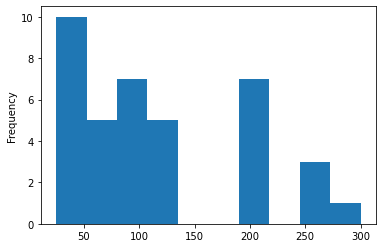

In [27]:
Cyclo_patients["AMOUNT"].plot.hist()

In [28]:
Counter(Cyclo_patients["AMOUNT"])

Counter({24.999999600000002: 2,
         49.999998: 2,
         100.000002: 6,
         50.0000016: 2,
         25.0000008: 2,
         125.00000743: 1,
         25.000003600000003: 1,
         250.000005: 1,
         300.000006: 1,
         50.00000016: 1,
         125.00000159999998: 1,
         200.0000064: 1,
         200.000004: 6,
         84.9999996: 1,
         120.000006: 1,
         120.0: 2,
         60.0000024: 3,
         61.00000244: 1,
         249.999995: 1,
         60.000000867: 1,
         250.00001: 1})

### Piperacillin

In [29]:
Pipe_patients = comb_data_2[comb_data_2["ITEMID"] == 225892]

In [30]:
np.unique(Pipe_patients["AMOUNTUOM"])

array(['dose', 'grams', 'mg'], dtype=object)

In [31]:
Pipe_patients_1 = Pipe_patients[Pipe_patients["AMOUNTUOM"] == 'dose']

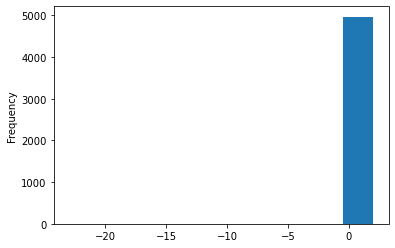

In [32]:
Pipe_patients_1["AMOUNT"].plot.hist()

In [33]:
np.unique(Pipe_patients_1["AMOUNT"])

array([-23., -17., -10.,  -1.,   0.,   1.,   2.])

In [34]:
Counter(Pipe_patients_1["AMOUNT"])

Counter({1.0: 4959, -23.0: 1, 2.0: 2, -1.0: 1, 0.0: 4, -17.0: 1, -10.0: 1})

In [35]:
Pipe_patients_2 = Pipe_patients[Pipe_patients["AMOUNTUOM"] == 'grams']

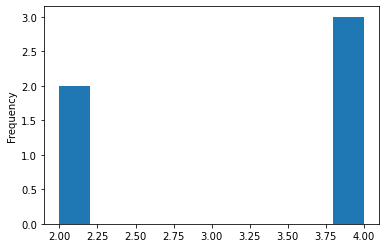

In [36]:
Pipe_patients_2["AMOUNT"].plot.hist()

In [37]:
Counter(Pipe_patients_2["AMOUNT"])

Counter({4.0: 3, 2.0: 2})

In [38]:
Pipe_patients_3 = Pipe_patients[Pipe_patients["AMOUNTUOM"] == 'mg']

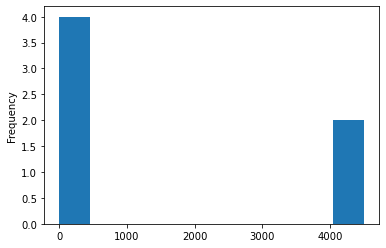

In [39]:
Pipe_patients_3["AMOUNT"].plot.hist()

In [40]:
Counter(Pipe_patients_3["AMOUNT"])

Counter({4.0000002: 4, 4500.0: 2})

### Vancomycin

In [41]:
Vanc_patients = comb_data_2[comb_data_2["ITEMID"] == 225798]

In [42]:
np.unique(Vanc_patients["AMOUNTUOM"])

array(['dose', 'grams', 'mcg', 'mg'], dtype=object)

In [43]:
Vanc_patients_1 = Vanc_patients[Vanc_patients["AMOUNTUOM"] == 'dose']

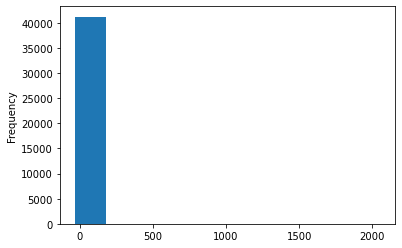

In [44]:
Vanc_patients_1["AMOUNT"].plot.hist()

In [45]:
np.unique(Vanc_patients_1["AMOUNT"])

array([-2.90e+01, -2.80e+01, -2.70e+01, -2.30e+01, -1.50e+01, -1.20e+01,
       -9.00e+00, -8.00e+00, -7.00e+00, -5.00e+00, -4.00e+00, -3.00e+00,
       -2.00e+00, -1.00e+00,  0.00e+00,  5.00e-01,  1.00e+00,  2.00e+00,
        8.00e+00,  1.60e+01,  2.50e+02,  5.00e+02,  7.50e+02,  1.00e+03,
        1.25e+03,  1.50e+03,  2.05e+03])

In [46]:
Counter(Vanc_patients_1["AMOUNT"])

Counter({1.0: 41166,
         500.0: 2,
         0.5: 7,
         1500.0: 1,
         1000.0: 7,
         -29.0: 1,
         -3.0: 1,
         0.0: 7,
         -7.0: 1,
         -5.0: 1,
         750.0: 1,
         1250.0: 3,
         -2.0: 2,
         -1.0: 3,
         -4.0: 3,
         16.0: 1,
         -28.0: 1,
         -15.0: 2,
         -8.0: 2,
         250.0: 5,
         -9.0: 1,
         2050.0: 1,
         2.0: 3,
         -27.0: 1,
         -12.0: 1,
         -23.0: 1,
         8.0: 2})

In [47]:
Vanc_patients_2 = Vanc_patients[Vanc_patients["AMOUNTUOM"] == 'grams']

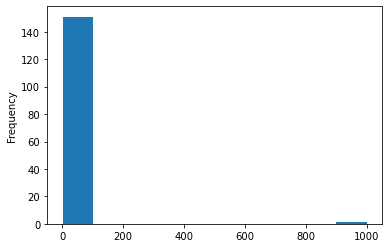

In [48]:
Vanc_patients_2["AMOUNT"].plot.hist()

In [49]:
Counter(Vanc_patients_2["AMOUNT"])

Counter({1.0: 139, 0.5: 1, 1.5: 10, 2.0: 1, 1000.0: 1})

In [50]:
Vanc_patients_3 = Vanc_patients[Vanc_patients["AMOUNTUOM"] == 'mcg']

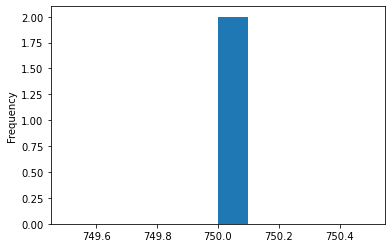

In [51]:
Vanc_patients_3["AMOUNT"].plot.hist()

In [52]:
Counter(Vanc_patients_3["AMOUNT"])

Counter({750.00001: 2})

In [53]:
Vanc_patients_4 = Vanc_patients[Vanc_patients["AMOUNTUOM"] == 'mg']

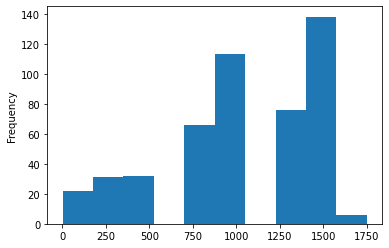

In [54]:
Vanc_patients_4["AMOUNT"].plot.hist()

In [55]:
Counter(Vanc_patients_4["AMOUNT"])

Counter({1000.0: 113,
         750.00006: 66,
         250.0: 31,
         1.0: 3,
         1250.0: 76,
         500.0: 32,
         1500.0001: 138,
         125.0: 16,
         2.0000001: 2,
         150.00001: 1,
         1750.0001: 6})

- Select the unit of the amount of above three medications
  - Cyclosporine (227534): mg
  - Piperacillin (225892): dose
  - Vancomycin (225798): dose

In [56]:
comb_data_2 = comb_data_2[comb_data_2["AMOUNTUOM"].isin(["mg", "dose"])]

In [57]:
comb_data_2 = comb_data_2[-((comb_data_2["ITEMID"] == 225798) & (comb_data_2["AMOUNTUOM"] == "mg"))]

In [58]:
comb_data_2 = comb_data_2[-((comb_data_2["ITEMID"] == 225892) & (comb_data_2["AMOUNTUOM"] == "mg"))]

In [59]:
Counter(comb_data_2["ITEMID"])

Counter({225892: 4969, 225798: 41227, 227534: 38})

## Time epoch

In [60]:
comb_data_2["STARTTIME"]

0        2181-02-21 06:00:00
1        2181-02-22 05:37:00
2        2156-03-05 09:14:00
3        2156-02-25 08:00:00
4        2156-03-06 08:00:00
                ...         
46878    2110-08-22 08:00:00
46879    2110-08-21 20:19:00
46880    2156-09-02 14:35:00
46881    2170-07-27 16:00:00
46882    2170-07-28 05:00:00
Name: STARTTIME, Length: 46234, dtype: object

In [61]:
comb_data_2["ENDTIME"]

0        2181-02-21 06:01:00
1        2181-02-22 05:38:00
2        2156-03-05 09:15:00
3        2156-02-25 08:01:00
4        2156-03-06 08:01:00
                ...         
46878    2110-08-22 08:01:00
46879    2110-08-21 20:20:00
46880    2156-09-02 14:36:00
46881    2170-07-27 16:01:00
46882    2170-07-28 05:01:00
Name: ENDTIME, Length: 46234, dtype: object

In [62]:
comb_data_2["STARTTIME"] = pd.to_datetime(comb_data_2["STARTTIME"])

In [63]:
comb_data_2["ENDTIME"] = pd.to_datetime(comb_data_2["ENDTIME"])

In [64]:
comb_data_2["TIMEDIFF"] = comb_data_2["ENDTIME"] - comb_data_2["STARTTIME"]

In [65]:
comb_data_2["TIMEDIFF"]

0       00:01:00
1       00:01:00
2       00:01:00
3       00:01:00
4       00:01:00
          ...   
46878   00:01:00
46879   00:01:00
46880   00:01:00
46881   00:01:00
46882   00:01:00
Name: TIMEDIFF, Length: 46234, dtype: timedelta64[ns]

In [66]:
Counter(comb_data_2["TIMEDIFF"])

Counter({Timedelta('0 days 00:01:00'): 46167,
         Timedelta('-1 days +23:37:00'): 2,
         Timedelta('-1 days +23:31:00'): 1,
         Timedelta('0 days 05:00:00'): 5,
         Timedelta('-1 days +23:57:00'): 1,
         Timedelta('-1 days +23:59:00'): 4,
         Timedelta('-1 days +23:53:00'): 1,
         Timedelta('-1 days +23:55:00'): 1,
         Timedelta('-1 days +23:58:00'): 2,
         Timedelta('-1 days +23:56:00'): 3,
         Timedelta('-1 days +23:32:00'): 1,
         Timedelta('0 days 00:00:00'): 4,
         Timedelta('-1 days +23:43:00'): 1,
         Timedelta('0 days 02:00:00'): 22,
         Timedelta('0 days 04:01:00'): 1,
         Timedelta('0 days 04:02:00'): 1,
         Timedelta('-1 days +23:50:00'): 1,
         Timedelta('-1 days +23:45:00'): 2,
         Timedelta('-1 days +23:52:00'): 2,
         Timedelta('-1 days +23:51:00'): 1,
         Timedelta('0 days 03:00:00'): 1,
         Timedelta('0 days 03:07:00'): 1,
         Timedelta('0 days 02:58:00'): 1,
 

In [67]:
comb_data_2 = comb_data_2.sort_values(by = ["ICUSTAY_ID", "STARTTIME"])

In [68]:
comb_data_2 = comb_data_2[comb_data_2["ICUSTAY_ID"].notna()]

In [69]:
comb_data_2.head(10)

,ROW_ID_x,SUBJECT_ID_x,HADM_ID_x,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,...,ROW_ID_y,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID,TIMEDIFF
23700,1737363,56369,198650,200033.0,2198-08-11 22:05:00,2198-08-11 22:06:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23696,1737878,56369,198650,200033.0,2198-08-12 04:05:00,2198-08-12 04:06:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23701,1737585,56369,198650,200033.0,2198-08-12 12:01:00,2198-08-12 12:02:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23703,1737905,56369,198650,200033.0,2198-08-12 20:20:00,2198-08-12 20:21:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23694,1737677,56369,198650,200033.0,2198-08-13 04:09:00,2198-08-13 04:10:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23693,1737338,56369,198650,200033.0,2198-08-13 11:02:00,2198-08-13 11:03:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23699,1737542,56369,198650,200033.0,2198-08-13 20:38:00,2198-08-13 20:39:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23691,1737620,56369,198650,200033.0,2198-08-14 04:04:00,2198-08-14 04:05:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23692,1737808,56369,198650,200033.0,2198-08-14 12:00:00,2198-08-14 12:01:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23704,1737720,56369,198650,200033.0,2198-08-18 09:11:00,2198-08-18 09:12:00,225798,1.0,dose,NaN,...,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00


In [70]:
Piperacillin_time_interval = comb_data_2[comb_data_2["LABEL"] == "Piperacillin"]

In [71]:
Piperacillin_time_interval = Piperacillin_time_interval[Piperacillin_time_interval["AMOUNTUOM"] == 'dose']

In [72]:
Piperacillin_time_interval

,ROW_ID_x,SUBJECT_ID_x,HADM_ID_x,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,...,ROW_ID_y,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID,TIMEDIFF
23700,1737363,56369,198650,200033.0,2198-08-11 22:05:00,2198-08-11 22:06:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23696,1737878,56369,198650,200033.0,2198-08-12 04:05:00,2198-08-12 04:06:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23701,1737585,56369,198650,200033.0,2198-08-12 12:01:00,2198-08-12 12:02:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23703,1737905,56369,198650,200033.0,2198-08-12 20:20:00,2198-08-12 20:21:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23694,1737677,56369,198650,200033.0,2198-08-13 04:09:00,2198-08-13 04:10:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17470,1306854,91074,106110,299872.0,2192-02-22 22:32:00,2192-02-22 22:33:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
17471,1306796,91074,106110,299872.0,2192-02-23 02:06:00,2192-02-23 02:07:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
20717,1557863,66165,131060,299880.0,2159-06-02 23:08:00,2159-06-02 23:09:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
20714,1557909,66165,131060,299880.0,2159-06-03 10:42:00,2159-06-03 10:43:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00


In [73]:
Piperacillin_time_interval_min = Piperacillin_time_interval[["ICUSTAY_ID", "STARTTIME"]].groupby("ICUSTAY_ID").min()

In [74]:
Piperacillin_time_interval_min

,STARTTIME
ICUSTAY_ID,
200033.0,2198-08-11 22:05:00
200087.0,2196-08-31 13:46:00
200095.0,2113-10-27 16:00:00
200143.0,2191-04-01 23:24:00
200191.0,2160-11-22 17:15:00
...,...
299518.0,2195-02-03 16:08:00
299698.0,2157-05-02 00:22:00
299867.0,2186-07-24 02:06:00


In [75]:
Piperacillin_time_interval_max = Piperacillin_time_interval[["ICUSTAY_ID", "ENDTIME"]].groupby("ICUSTAY_ID").max()

In [76]:
Piperacillin_time_interval_max

,ENDTIME
ICUSTAY_ID,
200033.0,2198-08-14 12:01:00
200087.0,2196-08-31 13:47:00
200095.0,2113-10-28 01:48:00
200143.0,2191-04-02 01:01:00
200191.0,2160-11-22 17:16:00
...,...
299518.0,2195-02-04 09:01:00
299698.0,2157-05-02 16:15:00
299867.0,2186-07-24 02:07:00


In [77]:
Piperacillin_time_interval_max["ENDTIME"] - Piperacillin_time_interval_min["STARTTIME"]

ICUSTAY_ID
200033.0   2 days 13:56:00
200087.0   0 days 00:01:00
200095.0   0 days 09:48:00
200143.0   0 days 01:37:00
200191.0   0 days 00:01:00
                 ...      
299518.0   0 days 16:53:00
299698.0   0 days 15:53:00
299867.0   0 days 00:01:00
299872.0   0 days 03:35:00
299880.0   0 days 18:53:00
Length: 1315, dtype: timedelta64[ns]

In [78]:
Cyclosporine_time_interval = comb_data_2[comb_data_2["LABEL"] == "Cyclosporine"]

In [79]:
Cyclosporine_time_interval

,ROW_ID_x,SUBJECT_ID_x,HADM_ID_x,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,...,ROW_ID_y,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID,TIMEDIFF
9687,668540,66508,131118,207606.0,2165-03-18 13:38:00,2165-03-18 17:39:00,227534,125.000007,mg,31.120334,...,14780,Cyclosporine,Cyclosporine,metavision,inputevents_mv,Medications,mg,Solution,NaN,04:01:00
9688,668269,66508,131118,207606.0,2165-03-27 19:00:00,2165-03-27 21:00:00,227534,25.000001,mg,12.500000,...,14780,Cyclosporine,Cyclosporine,metavision,inputevents_mv,Medications,mg,Solution,NaN,02:00:00
9690,667281,66508,131118,207606.0,2165-03-30 21:18:00,2165-03-31 01:20:00,227534,25.000004,mg,6.198348,...,14780,Cyclosporine,Cyclosporine,metavision,inputevents_mv,Medications,mg,Solution,NaN,04:02:00
13321,961542,17047,195476,212857.0,2136-09-27 11:45:00,2136-09-27 16:45:00,227534,250.000005,mg,50.000001,...,14780,Cyclosporine,Cyclosporine,metavision,inputevents_mv,Medications,mg,Solution,NaN,05:00:00
21628,1617527,72670,189049,215908.0,2116-07-06 10:11:00,2116-07-06 13:11:00,227534,300.000006,mg,100.000002,...,14780,Cyclosporine,Cyclosporine,metavision,inputevents_mv,Medications,mg,Solution,NaN,03:00:00
21631,1616116,72670,189049,215908.0,2116-07-06 10:11:00,2116-07-06 13:18:00,227534,50.000000,mg,16.042781,...,14780,Cyclosporine,Cyclosporine,metavision,inputevents_mv,Medications,mg,Solution,NaN,03:07:00
43350,3321053,45317,103029,221905.0,2118-05-24 23:00:00,2118-05-25 00:00:00,227534,120.000006,mg,120.000006,...,14780,Cyclosporine,Cyclosporine,metavision,inputevents_mv,Medications,mg,Solution,NaN,01:00:00
43352,3321196,45317,103029,221905.0,2118-05-24 23:00:00,2118-05-25 01:00:00,227534,120.000000,mg,60.000000,...,14780,Cyclosporine,Cyclosporine,metavision,inputevents_mv,Medications,mg,Solution,NaN,02:00:00
43351,3321129,45317,103029,221905.0,2118-05-25 10:15:00,2118-05-25 12:15:00,227534,120.000000,mg,60.000000,...,14780,Cyclosporine,Cyclosporine,metavision,inputevents_mv,Medications,mg,Solution,NaN,02:00:00
11017,788015,82313,116027,233187.0,2126-06-18 10:36:00,2126-06-18 12:36:00,227534,100.000002,mg,50.000001,...,14780,Cyclosporine,Cyclosporine,metavision,inputevents_mv,Medications,mg,Solution,NaN,02:00:00


In [80]:
Cyclosporine_time_interval_min = Cyclosporine_time_interval[["ICUSTAY_ID", "STARTTIME"]].groupby("ICUSTAY_ID").min()

In [81]:
Cyclosporine_time_interval_max = Cyclosporine_time_interval[["ICUSTAY_ID", "ENDTIME"]].groupby("ICUSTAY_ID").max()

In [82]:
Cyclosporine_time_interval_max["ENDTIME"] - Cyclosporine_time_interval_min["STARTTIME"]

ICUSTAY_ID
207606.0   12 days 11:42:00
212857.0    0 days 05:00:00
215908.0    0 days 03:07:00
221905.0    0 days 13:15:00
233187.0    1 days 14:24:00
255635.0    1 days 14:42:00
256983.0    0 days 02:00:00
282660.0    4 days 15:59:00
292824.0    1 days 06:21:00
295808.0    5 days 07:15:00
dtype: timedelta64[ns]

In [83]:
Vancomycin_time_interval = comb_data_2[comb_data_2["LABEL"] == "Vancomycin"]

In [84]:
Vancomycin_time_interval = Vancomycin_time_interval[Vancomycin_time_interval["AMOUNTUOM"] == 'dose']

In [85]:
Vancomycin_time_interval

,ROW_ID_x,SUBJECT_ID_x,HADM_ID_x,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,...,ROW_ID_y,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID,TIMEDIFF
23704,1737720,56369,198650,200033.0,2198-08-18 09:11:00,2198-08-18 09:12:00,225798,1.0,dose,NaN,...,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23698,1737752,56369,198650,200033.0,2198-08-18 20:00:00,2198-08-18 20:01:00,225798,1.0,dose,NaN,...,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23697,1737710,56369,198650,200033.0,2198-08-19 09:36:00,2198-08-19 09:37:00,225798,1.0,dose,NaN,...,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23695,1737576,56369,198650,200033.0,2198-08-19 20:03:00,2198-08-19 20:04:00,225798,1.0,dose,NaN,...,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23702,1737589,56369,198650,200033.0,2198-08-20 08:00:00,2198-08-20 08:01:00,225798,1.0,dose,NaN,...,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44676,3426779,98649,110990,299950.0,2122-06-21 20:13:00,2122-06-21 20:14:00,225798,1.0,dose,NaN,...,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
37283,2879081,50334,129555,299957.0,2132-10-13 20:00:00,2132-10-13 20:01:00,225798,1.0,dose,NaN,...,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
37284,2879111,50334,129555,299957.0,2132-10-14 09:45:00,2132-10-14 09:46:00,225798,1.0,dose,NaN,...,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
37281,2879045,50334,129555,299957.0,2132-10-14 21:00:00,2132-10-14 21:01:00,225798,1.0,dose,NaN,...,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00


In [86]:
Vancomycin_time_interval_min = Vancomycin_time_interval[["ICUSTAY_ID", "STARTTIME"]].groupby("ICUSTAY_ID").min()

In [87]:
Vancomycin_time_interval_max = Vancomycin_time_interval[["ICUSTAY_ID", "ENDTIME"]].groupby("ICUSTAY_ID").max()

In [88]:
Vancomycin_time_interval_max["ENDTIME"] - Vancomycin_time_interval_min["STARTTIME"]

ICUSTAY_ID
200033.0    1 days 22:50:00
200035.0    0 days 11:49:00
200063.0   12 days 08:01:00
200075.0    1 days 02:25:00
200087.0    2 days 15:22:00
                 ...       
299914.0    0 days 00:01:00
299930.0    0 days 10:01:00
299949.0    1 days 12:12:00
299950.0    0 days 22:44:00
299957.0    1 days 12:31:00
Length: 8074, dtype: timedelta64[ns]

In [89]:
comb_data_2.head(10)

,ROW_ID_x,SUBJECT_ID_x,HADM_ID_x,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,...,ROW_ID_y,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID,TIMEDIFF
23700,1737363,56369,198650,200033.0,2198-08-11 22:05:00,2198-08-11 22:06:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23696,1737878,56369,198650,200033.0,2198-08-12 04:05:00,2198-08-12 04:06:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23701,1737585,56369,198650,200033.0,2198-08-12 12:01:00,2198-08-12 12:02:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23703,1737905,56369,198650,200033.0,2198-08-12 20:20:00,2198-08-12 20:21:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23694,1737677,56369,198650,200033.0,2198-08-13 04:09:00,2198-08-13 04:10:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23693,1737338,56369,198650,200033.0,2198-08-13 11:02:00,2198-08-13 11:03:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23699,1737542,56369,198650,200033.0,2198-08-13 20:38:00,2198-08-13 20:39:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23691,1737620,56369,198650,200033.0,2198-08-14 04:04:00,2198-08-14 04:05:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23692,1737808,56369,198650,200033.0,2198-08-14 12:00:00,2198-08-14 12:01:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23704,1737720,56369,198650,200033.0,2198-08-18 09:11:00,2198-08-18 09:12:00,225798,1.0,dose,NaN,...,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00


In [90]:
comb_data_2 = comb_data_2.sort_values(by = ["ICUSTAY_ID", "STARTTIME"])

In [91]:
comb_data_2.head(40)

,ROW_ID_x,SUBJECT_ID_x,HADM_ID_x,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,...,ROW_ID_y,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID,TIMEDIFF
23700,1737363,56369,198650,200033.0,2198-08-11 22:05:00,2198-08-11 22:06:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23696,1737878,56369,198650,200033.0,2198-08-12 04:05:00,2198-08-12 04:06:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23701,1737585,56369,198650,200033.0,2198-08-12 12:01:00,2198-08-12 12:02:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23703,1737905,56369,198650,200033.0,2198-08-12 20:20:00,2198-08-12 20:21:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23694,1737677,56369,198650,200033.0,2198-08-13 04:09:00,2198-08-13 04:10:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23693,1737338,56369,198650,200033.0,2198-08-13 11:02:00,2198-08-13 11:03:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23699,1737542,56369,198650,200033.0,2198-08-13 20:38:00,2198-08-13 20:39:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23691,1737620,56369,198650,200033.0,2198-08-14 04:04:00,2198-08-14 04:05:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23692,1737808,56369,198650,200033.0,2198-08-14 12:00:00,2198-08-14 12:01:00,225892,1.0,dose,NaN,...,14048,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00
23704,1737720,56369,198650,200033.0,2198-08-18 09:11:00,2198-08-18 09:12:00,225798,1.0,dose,NaN,...,13982,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00


In [92]:
len(pd.unique(comb_data_2["ICUSTAY_ID"]))

8260

In [93]:
comb_data_2["TimeInt"] = comb_data_2["STARTTIME"] - comb_data_2["STARTTIME"]

In [94]:
comb_data_2["TimeInt"].iloc[0]

Timedelta('0 days 00:00:00')

In [95]:
for i in range(1, len(comb_data_2)):
    if comb_data_2["ICUSTAY_ID"].iloc[i] != comb_data_2["ICUSTAY_ID"].iloc[i-1]:
        comb_data_2["TimeInt"].iloc[i] = comb_data_2["TimeInt"].iloc[0]
    else:
        comb_data_2["TimeInt"].iloc[i] = comb_data_2["STARTTIME"].iloc[i] - comb_data_2["STARTTIME"].iloc[i-1]

D:\Programming\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [96]:
comb_data_2.head(10)

,ROW_ID_x,SUBJECT_ID_x,HADM_ID_x,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,...,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID,TIMEDIFF,TimeInt
23700,1737363,56369,198650,200033.0,2198-08-11 22:05:00,2198-08-11 22:06:00,225892,1.0,dose,NaN,...,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,0 days 00:00:00
23696,1737878,56369,198650,200033.0,2198-08-12 04:05:00,2198-08-12 04:06:00,225892,1.0,dose,NaN,...,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,0 days 06:00:00
23701,1737585,56369,198650,200033.0,2198-08-12 12:01:00,2198-08-12 12:02:00,225892,1.0,dose,NaN,...,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,0 days 07:56:00
23703,1737905,56369,198650,200033.0,2198-08-12 20:20:00,2198-08-12 20:21:00,225892,1.0,dose,NaN,...,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,0 days 08:19:00
23694,1737677,56369,198650,200033.0,2198-08-13 04:09:00,2198-08-13 04:10:00,225892,1.0,dose,NaN,...,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,0 days 07:49:00
23693,1737338,56369,198650,200033.0,2198-08-13 11:02:00,2198-08-13 11:03:00,225892,1.0,dose,NaN,...,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,0 days 06:53:00
23699,1737542,56369,198650,200033.0,2198-08-13 20:38:00,2198-08-13 20:39:00,225892,1.0,dose,NaN,...,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,0 days 09:36:00
23691,1737620,56369,198650,200033.0,2198-08-14 04:04:00,2198-08-14 04:05:00,225892,1.0,dose,NaN,...,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,0 days 07:26:00
23692,1737808,56369,198650,200033.0,2198-08-14 12:00:00,2198-08-14 12:01:00,225892,1.0,dose,NaN,...,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,0 days 07:56:00
23704,1737720,56369,198650,200033.0,2198-08-18 09:11:00,2198-08-18 09:12:00,225798,1.0,dose,NaN,...,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,3 days 21:11:00


In [97]:
comb_data_2["LOS"]

23700    13.8771
23696    13.8771
23701    13.8771
23703    13.8771
23694    13.8771
          ...   
44676     2.2052
37283     2.0900
37284     2.0900
37281     2.0900
37282     2.0900
Name: LOS, Length: 46234, dtype: float64

In [98]:
comb_data_2a = comb_data_2[comb_data_2["TimeInt"] != "0 days 00:00:00"]

In [99]:
comb_data_2a["TimeInt"].describe()

count                     37300
mean     0 days 15:45:13.249865
std      1 days 01:49:11.013878
min             0 days 00:01:00
25%             0 days 07:39:00
50%             0 days 11:35:00
75%             0 days 13:37:00
max            57 days 00:14:00
Name: TimeInt, dtype: object

In [100]:
Counter(comb_data_2["HYPERTENSION_ICD"])

Counter({1: 20680, 0: 25554})

Code patients' data as discrete time series with 12-h time steps (need discussion)

In [101]:
from plotnine import *

In [102]:
example_1 = comb_data_2[comb_data_2["ICUSTAY_ID"] == 200033.0]

In [103]:
example_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 23700 to 23702
Columns: 203 entries, ROW_ID_x to TimeInt
dtypes: datetime64[ns](2), float64(108), int64(71), object(20), timedelta64[ns](2)
memory usage: 22.3+ KB


In [104]:
cumsum_1 = example_1.loc[example_1["LABEL"] == "Piperacillin", "AMOUNT"].cumsum()

In [105]:
cumsum_1 = pd.DataFrame(cumsum_1)

In [106]:
cumsum_1

,AMOUNT
23700,1.0
23696,2.0
23701,3.0
23703,4.0
23694,5.0
23693,6.0
23699,7.0
23691,8.0
23692,9.0


In [107]:
cumsum_2 = pd.DataFrame(example_1.loc[example_1["LABEL"] == "Vancomycin", "AMOUNT"].cumsum())

In [108]:
cumsum_2

,AMOUNT
23704,1.0
23698,2.0
23697,3.0
23695,4.0
23702,5.0


In [109]:
example_1["CUMSUM"] = pd.concat([cumsum_1, cumsum_2], axis=0)

D:\Programming\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [110]:
example_1 = example_1[example_1["TimeInt"] != "0 days 00:00:00"]

In [111]:
example_1

,ROW_ID_x,SUBJECT_ID_x,HADM_ID_x,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,...,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID,TIMEDIFF,TimeInt,CUMSUM
23696,1737878,56369,198650,200033.0,2198-08-12 04:05:00,2198-08-12 04:06:00,225892,1.0,dose,NaN,...,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,0 days 06:00:00,2.0
23701,1737585,56369,198650,200033.0,2198-08-12 12:01:00,2198-08-12 12:02:00,225892,1.0,dose,NaN,...,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,0 days 07:56:00,3.0
23703,1737905,56369,198650,200033.0,2198-08-12 20:20:00,2198-08-12 20:21:00,225892,1.0,dose,NaN,...,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,0 days 08:19:00,4.0
23694,1737677,56369,198650,200033.0,2198-08-13 04:09:00,2198-08-13 04:10:00,225892,1.0,dose,NaN,...,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,0 days 07:49:00,5.0
23693,1737338,56369,198650,200033.0,2198-08-13 11:02:00,2198-08-13 11:03:00,225892,1.0,dose,NaN,...,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,0 days 06:53:00,6.0
23699,1737542,56369,198650,200033.0,2198-08-13 20:38:00,2198-08-13 20:39:00,225892,1.0,dose,NaN,...,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,0 days 09:36:00,7.0
23691,1737620,56369,198650,200033.0,2198-08-14 04:04:00,2198-08-14 04:05:00,225892,1.0,dose,NaN,...,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,0 days 07:26:00,8.0
23692,1737808,56369,198650,200033.0,2198-08-14 12:00:00,2198-08-14 12:01:00,225892,1.0,dose,NaN,...,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,0 days 07:56:00,9.0
23704,1737720,56369,198650,200033.0,2198-08-18 09:11:00,2198-08-18 09:12:00,225798,1.0,dose,NaN,...,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,3 days 21:11:00,1.0
23698,1737752,56369,198650,200033.0,2198-08-18 20:00:00,2198-08-18 20:01:00,225798,1.0,dose,NaN,...,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,0 days 10:49:00,2.0


In [112]:
example_1["TimeInt"].mean()

Timedelta('0 days 15:31:55.384615')

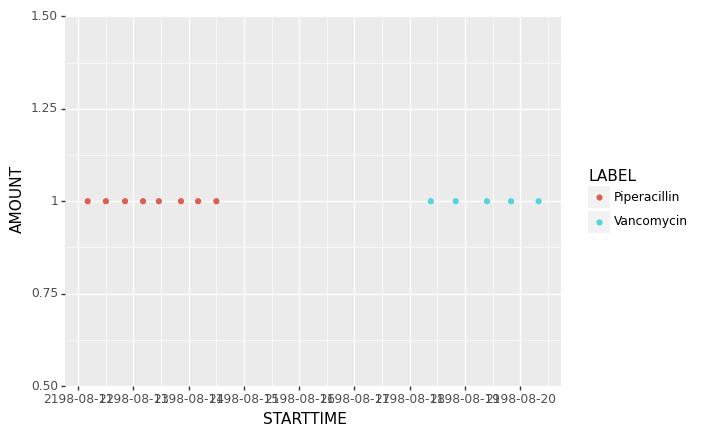

<ggplot: (131139228799)>

In [113]:
ggplot(example_1, aes(x = 'STARTTIME', y = 'AMOUNT', colour = 'LABEL')) + geom_point()

In [114]:
example_1['STARTTIME'].dt.day

23696    12
23701    12
23703    12
23694    13
23693    13
23699    13
23691    14
23692    14
23704    18
23698    18
23697    19
23695    19
23702    20
Name: STARTTIME, dtype: int64

In [115]:
example_1a = example_1.pivot(index = "STARTTIME", columns = "LABEL", values = "CUMSUM")

In [116]:
example_1a

LABEL,Piperacillin,Vancomycin
STARTTIME,,
2198-08-12 04:05:00,2.0,NaN
2198-08-12 12:01:00,3.0,NaN
2198-08-12 20:20:00,4.0,NaN
2198-08-13 04:09:00,5.0,NaN
2198-08-13 11:02:00,6.0,NaN
2198-08-13 20:38:00,7.0,NaN
2198-08-14 04:04:00,8.0,NaN
2198-08-14 12:00:00,9.0,NaN
2198-08-18 09:11:00,NaN,1.0


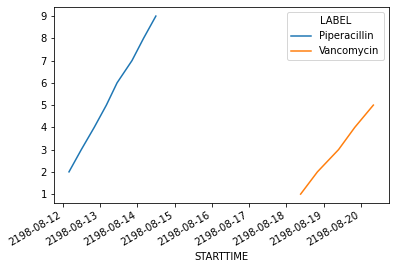

In [117]:
example_1a["2198-08-11 22:05:00":"2198-08-20 08:00:00"].plot()

In [118]:
example_1["MECHANICAL_VENTILATION_ICD"]

23696    1
23701    1
23703    1
23694    1
23693    1
23699    1
23691    1
23692    1
23704    1
23698    1
23697    1
23695    1
23702    1
Name: MECHANICAL_VENTILATION_ICD, dtype: int64

In [119]:
comb_data_2

,ROW_ID_x,SUBJECT_ID_x,HADM_ID_x,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,...,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID,TIMEDIFF,TimeInt
23700,1737363,56369,198650,200033.0,2198-08-11 22:05:00,2198-08-11 22:06:00,225892,1.0,dose,NaN,...,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,00:00:00
23696,1737878,56369,198650,200033.0,2198-08-12 04:05:00,2198-08-12 04:06:00,225892,1.0,dose,NaN,...,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,06:00:00
23701,1737585,56369,198650,200033.0,2198-08-12 12:01:00,2198-08-12 12:02:00,225892,1.0,dose,NaN,...,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,07:56:00
23703,1737905,56369,198650,200033.0,2198-08-12 20:20:00,2198-08-12 20:21:00,225892,1.0,dose,NaN,...,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,08:19:00
23694,1737677,56369,198650,200033.0,2198-08-13 04:09:00,2198-08-13 04:10:00,225892,1.0,dose,NaN,...,Piperacillin,Piperacillin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,07:49:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44676,3426779,98649,110990,299950.0,2122-06-21 20:13:00,2122-06-21 20:14:00,225798,1.0,dose,NaN,...,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,12:06:00
37283,2879081,50334,129555,299957.0,2132-10-13 20:00:00,2132-10-13 20:01:00,225798,1.0,dose,NaN,...,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,00:00:00
37284,2879111,50334,129555,299957.0,2132-10-14 09:45:00,2132-10-14 09:46:00,225798,1.0,dose,NaN,...,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,13:45:00
37281,2879045,50334,129555,299957.0,2132-10-14 21:00:00,2132-10-14 21:01:00,225798,1.0,dose,NaN,...,Vancomycin,Vancomycin,metavision,inputevents_mv,Antibiotics,dose,Solution,NaN,00:01:00,11:15:00


In [120]:
Counter(comb_data_2["LABEL"])

Counter({'Piperacillin': 4969, 'Vancomycin': 41227, 'Cyclosporine': 38})

In [121]:
Pip_dist = comb_data_2[comb_data_2["LABEL"] == "Piperacillin"]

In [122]:
Van_dist = comb_data_2[comb_data_2["LABEL"] == "Vancomycin"]

In [123]:
Cyc_dist = comb_data_2[comb_data_2["LABEL"] == "Cyclosporine"]

In [124]:
Pip_dist["TimeInt"].describe().T

count                      4969
mean     0 days 08:06:49.579392
std      0 days 17:21:12.410763
min             0 days 00:00:00
25%             0 days 02:14:00
50%             0 days 06:00:00
75%             0 days 08:00:00
max            13 days 13:06:00
Name: TimeInt, dtype: object

In [125]:
import seaborn as sns

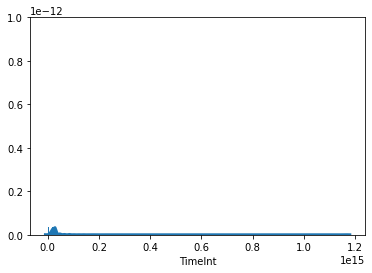

In [126]:
sns.distplot(Pip_dist["TimeInt"], hist = True, kde = True,
             bins = 200, 
             hist_kws={"linewidth": 15,'alpha':1}, 
             kde_kws = {'linewidth': 3})

In [127]:
Van_dist["TimeInt"].describe().T

count                     41227
mean     0 days 13:16:08.465811
std      1 days 00:38:34.993751
min             0 days 00:00:00
25%             0 days 03:44:30
50%             0 days 11:00:00
75%             0 days 12:53:00
max            57 days 00:14:00
Name: TimeInt, dtype: object

In [128]:
Cyc_dist["TimeInt"].describe().T

count                        38
mean     0 days 06:39:41.052631
std      0 days 09:36:46.351533
min             0 days 00:00:00
25%             0 days 00:00:00
50%             0 days 02:19:00
75%             0 days 11:36:45
max             1 days 11:13:00
Name: TimeInt, dtype: object

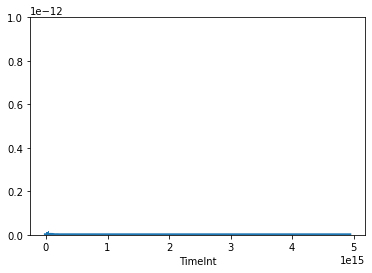

In [129]:
sns.distplot(Van_dist["TimeInt"], hist = True, kde = True,
             bins = 200, 
             hist_kws={"linewidth": 15,'alpha':1}, 
             kde_kws = {'linewidth': 3})

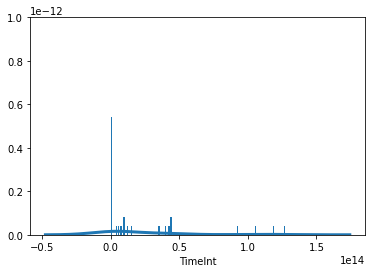

In [130]:
sns.distplot(Cyc_dist["TimeInt"], hist = True, kde = True,
             bins = 200, 
             hist_kws={"linewidth": 15,'alpha':1}, 
             kde_kws = {'linewidth': 3})

In [131]:
Cyclo_list = comb_data_2[comb_data_2['ITEMID'] == 227534]

In [132]:
Pipera_list = comb_data_2[comb_data_2['ITEMID'] == 225892]

In [133]:
Vanco_list = comb_data_2[comb_data_2['ITEMID'] == 225798]

- Cyclosporine

In [134]:
patient_list_1 = pd.unique(Cyclo_list["ICUSTAY_ID"])

In [135]:
data_TimeInt_1 = {'ICUSTAY_ID':[], 'START':[], 'END':[]} 

In [136]:
for i in range(len(patient_list_1)):
    data_TimeInt_1['ICUSTAY_ID'].append(patient_list_1[i])
    data_TimeInt_1['START'].append(Cyclo_list[Cyclo_list["ICUSTAY_ID"] == patient_list_1[i]]["STARTTIME"].iloc[0])
    data_TimeInt_1['END'].append(Cyclo_list[Cyclo_list["ICUSTAY_ID"] == patient_list_1[i]]["STARTTIME"].iloc[-1])

In [137]:
data_TimeInt_df_1 = pd.DataFrame(data_TimeInt_1) 

In [138]:
data_TimeInt_df_1

,ICUSTAY_ID,START,END
0,207606.0,2165-03-18 13:38:00,2165-03-30 21:18:00
1,212857.0,2136-09-27 11:45:00,2136-09-27 11:45:00
2,215908.0,2116-07-06 10:11:00,2116-07-06 10:11:00
3,221905.0,2118-05-24 23:00:00,2118-05-25 10:15:00
4,233187.0,2126-06-18 10:36:00,2126-06-19 23:00:00
5,255635.0,2168-06-13 00:18:00,2168-06-14 10:00:00
6,256983.0,2111-09-07 10:00:00,2111-09-07 10:00:00
7,282660.0,2167-11-07 10:15:00,2167-11-12 00:14:00
8,292824.0,2138-08-17 23:59:00,2138-08-18 22:00:00
9,295808.0,2153-03-27 14:45:00,2153-04-01 20:00:00


In [139]:
data_1 = {'ICUSTAY_ID':[], 'AMOUNT':[]}

In [140]:
for i in range(len(patient_list_1)):
    index = data_TimeInt_1["START"][i]
    
    while index < data_TimeInt_1["END"][i]:
        
        data_1['ICUSTAY_ID'].append(patient_list_1[i])
        
        index = index + pd.Timedelta('0 days 12:00:00')
        
        data_1['AMOUNT'].append(Cyclo_list.loc[((Cyclo_list["STARTTIME"] <= index) & (Cyclo_list["ICUSTAY_ID"] == patient_list_1[i])), "AMOUNT"].sum())
        
    index = data_TimeInt_1["END"][i]
    
    data_1['ICUSTAY_ID'].append(patient_list_1[i])
    data_1['AMOUNT'].append(Cyclo_list.loc[((Cyclo_list["STARTTIME"] <= index) & (Cyclo_list["ICUSTAY_ID"] == patient_list_1[i])), "AMOUNT"].sum())

- Piperacillin

In [141]:
patient_list_2 = pd.unique(Pipera_list["ICUSTAY_ID"])

In [142]:
data_TimeInt_2 = {'ICUSTAY_ID':[], 'START':[], 'END':[]} 

In [143]:
for i in range(len(patient_list_2)):
    data_TimeInt_2['ICUSTAY_ID'].append(patient_list_2[i])
    data_TimeInt_2['START'].append(Pipera_list[Pipera_list["ICUSTAY_ID"] == patient_list_2[i]]["STARTTIME"].iloc[0])
    data_TimeInt_2['END'].append(Pipera_list[Pipera_list["ICUSTAY_ID"] == patient_list_2[i]]["STARTTIME"].iloc[-1])

In [144]:
data_TimeInt_df_2 = pd.DataFrame(data_TimeInt_2) 

In [145]:
data_2 = {'ICUSTAY_ID':[], 'AMOUNT':[]}

In [146]:
for i in range(len(patient_list_2)):
    index = data_TimeInt_2["START"][i]
    
    while index < data_TimeInt_2["END"][i]:
        
        data_2['ICUSTAY_ID'].append(patient_list_2[i])
        
        index = index + pd.Timedelta('0 days 12:00:00')
        
        data_2['AMOUNT'].append(Pipera_list.loc[((Pipera_list["STARTTIME"] <= index) & (Pipera_list["ICUSTAY_ID"] == patient_list_2[i])), "AMOUNT"].sum())
        
    index = data_TimeInt_2["END"][i]
    
    data_2['ICUSTAY_ID'].append(patient_list_2[i])
    data_2['AMOUNT'].append(Pipera_list.loc[((Pipera_list["STARTTIME"] <= index) & (Pipera_list["ICUSTAY_ID"] == patient_list_2[i])), "AMOUNT"].sum())

- Vancomycin

In [147]:
patient_list_3 = pd.unique(Vanco_list["ICUSTAY_ID"])

In [148]:
data_TimeInt_3 = {'ICUSTAY_ID':[], 'START':[], 'END':[]} 

In [149]:
for i in range(len(patient_list_3)):
    data_TimeInt_3['ICUSTAY_ID'].append(patient_list_3[i])
    data_TimeInt_3['START'].append(Vanco_list[Vanco_list["ICUSTAY_ID"] == patient_list_3[i]]["STARTTIME"].iloc[0])
    data_TimeInt_3['END'].append(Vanco_list[Vanco_list["ICUSTAY_ID"] == patient_list_3[i]]["STARTTIME"].iloc[-1])

In [150]:
data_TimeInt_df_3 = pd.DataFrame(data_TimeInt_3) 

In [151]:
data_3 = {'ICUSTAY_ID':[], 'AMOUNT':[]}

In [152]:
for i in range(len(patient_list_3)):
    index = data_TimeInt_3["START"][i]
    
    while index < data_TimeInt_3["END"][i]:
        
        data_3['ICUSTAY_ID'].append(patient_list_3[i])
        
        index = index + pd.Timedelta('0 days 12:00:00')
        
        data_3['AMOUNT'].append(Vanco_list.loc[((Vanco_list["STARTTIME"] <= index) & (Vanco_list["ICUSTAY_ID"] == patient_list_3[i])), "AMOUNT"].sum())
        
    index = data_TimeInt_3["END"][i]
    
    data_3['ICUSTAY_ID'].append(patient_list_3[i])
    data_3['AMOUNT'].append(Vanco_list.loc[((Vanco_list["STARTTIME"] <= index) & (Vanco_list["ICUSTAY_ID"] == patient_list_3[i])), "AMOUNT"].sum())

In [153]:
data_1 = pd.DataFrame(data_1)

In [154]:
data_2 = pd.DataFrame(data_2)

In [155]:
data_3 = pd.DataFrame(data_3)

In [156]:
data_1["Diff"] = 0

In [157]:
for i in range(1, len(data_1)):
    if data_1["ICUSTAY_ID"].iloc[i] != data_1["ICUSTAY_ID"].iloc[i-1]:
        data_1["Diff"].iloc[i] = data_1["AMOUNT"].iloc[i]
    else:
        data_1["Diff"].iloc[i] = data_1["AMOUNT"].iloc[i] - data_1["AMOUNT"].iloc[i-1]
        
data_1["Diff"].iloc[0] = data_1["AMOUNT"].iloc[0]

D:\Programming\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [158]:
data_1

,ICUSTAY_ID,AMOUNT,Diff
0,207606.0,125.000007,125.000007
1,207606.0,125.000007,0.000000
2,207606.0,125.000007,0.000000
3,207606.0,125.000007,0.000000
4,207606.0,125.000007,0.000000
...,...,...,...
61,295808.0,150.000004,0.000000
62,295808.0,150.000004,0.000000
63,295808.0,150.000004,0.000000
64,295808.0,175.000004,25.000001


In [159]:
data_2["Diff"] = 0

In [160]:
for i in range(1, len(data_2)):
    if data_2["ICUSTAY_ID"].iloc[i] != data_2["ICUSTAY_ID"].iloc[i-1]:
        data_2["Diff"].iloc[i] = data_2["AMOUNT"].iloc[i]
    else:
        data_2["Diff"].iloc[i] = data_2["AMOUNT"].iloc[i] - data_2["AMOUNT"].iloc[i-1]
        
data_2["Diff"].iloc[0] = data_2["AMOUNT"].iloc[0]

D:\Programming\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [161]:
data_2

,ICUSTAY_ID,AMOUNT,Diff
0,200033.0,2.0,2.0
1,200033.0,4.0,2.0
2,200033.0,5.0,1.0
3,200033.0,7.0,2.0
4,200033.0,8.0,1.0
...,...,...,...
5624,299872.0,2.0,2.0
5625,299872.0,2.0,0.0
5626,299880.0,2.0,2.0
5627,299880.0,3.0,1.0


In [162]:
data_3["Diff"] = 0

In [163]:
for i in range(1, len(data_3)):
    if data_3["ICUSTAY_ID"].iloc[i] != data_3["ICUSTAY_ID"].iloc[i-1]:
        data_3["Diff"].iloc[i] = data_3["AMOUNT"].iloc[i]
    else:
        data_3["Diff"].iloc[i] = data_3["AMOUNT"].iloc[i] - data_3["AMOUNT"].iloc[i-1]
        
data_3["Diff"].iloc[0] = data_3["AMOUNT"].iloc[0]

D:\Programming\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [164]:
data_3

,ICUSTAY_ID,AMOUNT,Diff
0,200033.0,2.0,2.0
1,200033.0,2.0,0.0
2,200033.0,4.0,2.0
3,200033.0,5.0,1.0
4,200033.0,5.0,0.0
...,...,...,...
58269,299957.0,1.0,1.0
58270,299957.0,2.0,1.0
58271,299957.0,3.0,1.0
58272,299957.0,4.0,1.0


## Distribution Analysis

- Cyclosporine

In [165]:
data_1["Diff"].describe().T

count     66.000000
mean      66.984850
std      120.877625
min        0.000000
25%        0.000000
50%        0.000000
75%       82.499999
max      491.000003
Name: Diff, dtype: float64

- Piperacillin

In [166]:
data_2["Diff"].describe().T

count    5629.000000
mean        0.872624
std         0.988893
min       -23.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: Diff, dtype: float64

    Note the minimum value is -23, so maybe we should convert all these abnormal amount value into one

- Vancomycin

In [167]:
data_3["Diff"].describe().T

count    58274.000000
mean         1.000438
std         18.540684
min        -28.000000
25%          0.000000
50%          1.000000
75%          1.000000
max       2051.000000
Name: Diff, dtype: float64

    Note that there is the same problem as the dataset of Piperacillin

## Dynamic Variables

In [168]:
import dask.array as da 
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

In [170]:
chart_events = dd.read_csv('E:\\CHARTEVENTS.csv', dtype={'CGID': 'float64', 'ICUSTAY_ID': 'float64', 'ERROR': 'float64',
                                                         'RESULTSTATUS': 'object', 'STOPPED': 'object','VALUE': 'object',
                                                         'VALUENUM': 'float64',
                                                         'WARNING': 'float64'}, low_memory=False)

In [171]:
chart_events.dtypes

ROW_ID            int64
SUBJECT_ID        int64
HADM_ID           int64
ICUSTAY_ID      float64
ITEMID            int64
CHARTTIME        object
STORETIME        object
CGID            float64
VALUE            object
VALUENUM        float64
VALUEUOM         object
WARNING         float64
ERROR           float64
RESULTSTATUS     object
STOPPED          object
dtype: object

In [172]:
chart_events.head(100000)

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,788,36,165660,241249.0,223834,2134-05-12 12:00:00,2134-05-12 13:56:00,17525.0,15,15.00,L/min,0.0,0.0,NaN,NaN
1,789,36,165660,241249.0,223835,2134-05-12 12:00:00,2134-05-12 13:56:00,17525.0,100,100.00,NaN,0.0,0.0,NaN,NaN
2,790,36,165660,241249.0,224328,2134-05-12 12:00:00,2134-05-12 12:18:00,20823.0,.37,0.37,NaN,0.0,0.0,NaN,NaN
3,791,36,165660,241249.0,224329,2134-05-12 12:00:00,2134-05-12 12:19:00,20823.0,6,6.00,min,0.0,0.0,NaN,NaN
4,792,36,165660,241249.0,224330,2134-05-12 12:00:00,2134-05-12 12:19:00,20823.0,2.5,2.50,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,103269,822,101322,250288.0,220052,2182-02-15 11:00:00,2182-02-15 11:21:00,17250.0,107,107.00,mmHg,0.0,0.0,NaN,NaN
99996,103270,822,101322,250288.0,220210,2182-02-15 11:00:00,2182-02-15 11:21:00,17250.0,13,13.00,insp/min,0.0,0.0,NaN,NaN
99997,103271,822,101322,250288.0,220277,2182-02-15 11:00:00,2182-02-15 11:21:00,17250.0,100,100.00,%,0.0,0.0,NaN,NaN
99998,103272,822,101322,250288.0,220045,2182-02-15 12:00:00,2182-02-15 13:26:00,17250.0,51,51.00,bpm,0.0,0.0,NaN,NaN


In [173]:
patient_list = pd.unique(comb_data_2["ICUSTAY_ID"])

In [174]:
len(patient_list)

8260

In [175]:
chart_events = chart_events[chart_events.ICUSTAY_ID.isin(patient_list)]

In [176]:
chart_events.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
115,263,23,124321,234044.0,220180,2157-10-22 10:00:00,2157-10-22 10:26:00,19907.0,58,58.0,mmHg,0.0,0.0,NaN,NaN
116,264,23,124321,234044.0,220181,2157-10-22 10:00:00,2157-10-22 10:26:00,19907.0,70,70.0,mmHg,0.0,0.0,NaN,NaN
117,265,23,124321,234044.0,220210,2157-10-22 10:00:00,2157-10-22 10:26:00,19907.0,16,16.0,insp/min,0.0,0.0,NaN,NaN
118,266,23,124321,234044.0,220277,2157-10-22 10:00:00,2157-10-22 10:26:00,19907.0,98,98.0,%,0.0,0.0,NaN,NaN
119,267,23,124321,234044.0,225664,2157-10-22 10:00:00,2157-10-22 09:56:00,20009.0,188,188.0,NaN,0.0,0.0,NaN,NaN


In [177]:
chart_events.tail()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
420803,330471885,99781,147562,200664.0,224847,2133-08-02 08:30:00,2133-08-02 08:30:00,14357.0,Moderate,NaN,NaN,0.0,0.0,NaN,NaN
420804,330471886,99781,147562,200664.0,224889,2133-08-02 08:30:00,2133-08-02 08:31:00,14357.0,Not applicable,NaN,NaN,0.0,0.0,NaN,NaN
420805,330471887,99781,147562,200664.0,224903,2133-08-02 08:30:00,2133-08-02 08:31:00,14357.0,None,NaN,NaN,0.0,0.0,NaN,NaN
420806,330471888,99781,147562,200664.0,224910,2133-08-02 08:30:00,2133-08-02 08:31:00,14357.0,None,NaN,NaN,0.0,0.0,NaN,NaN
420807,330471889,99781,147562,200664.0,224930,2133-08-02 08:30:00,2133-08-02 08:30:00,14357.0,Back,NaN,NaN,0.0,0.0,NaN,NaN


In [178]:
chart_events_pd_1 = chart_events.compute()

In [179]:
len(pd.unique(chart_events_pd_1["ICUSTAY_ID"]))

8260

In [180]:
patient_list_1 = pd.unique(df_AKI["ICUSTAY_ID"])

In [181]:
len(patient_list_1)

21876

In [182]:
ICU_patient = {"ICUSTAY_ID": patient_list}

In [183]:
ICU_patient = pd.DataFrame(ICU_patient)

In [184]:
ICU_patient[ICU_patient["ICUSTAY_ID"] == 200664.0]

,ICUSTAY_ID
47,200664.0


========================================================================

In [185]:
chart_info = med_info[med_info["LINKSTO"] == "chartevents"]

In [186]:
chart_info = chart_info[chart_info["DBSOURCE"] == "metavision"]

In [187]:
chart_info

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
8683,13772,225175,See chart for initial patient assessment,See chart for initial patient assessment,metavision,chartevents,Adm History/FHPA,NaN,Checkbox,NaN
8684,13773,225176,Range of Motion Status,ROM Status,metavision,chartevents,Treatments,NaN,Text,NaN
8685,13774,225180,PT Splint Status #1,PT Splint Status #1,metavision,chartevents,Treatments,NaN,Text,NaN
8686,13775,225182,PT Splint Status #2,PT Splint Status #2,metavision,chartevents,Treatments,NaN,Text,NaN
8687,13776,225183,Current Goal,Current Goal,metavision,chartevents,Dialysis,mL,Numeric,NaN
...,...,...,...,...,...,...,...,...,...,...
12482,14518,226757,GCSMotorApacheIIValue,GCSMotorApacheIIValue,metavision,chartevents,Scores - APACHE II,NaN,Text,NaN
12483,14519,226758,GCSVerbalApacheIIValue,GCSVerbalApacheIIValue,metavision,chartevents,Scores - APACHE II,NaN,Text,NaN
12484,14520,226759,HCO3ApacheIIValue,HCO3ApacheIIValue,metavision,chartevents,Scores - APACHE II,None,Numeric,NaN
12485,14521,226760,HCO3Score,HCO3Score,metavision,chartevents,Scores - APACHE II,None,Numeric,NaN


In [188]:
Counter(chart_info["CATEGORY"])

Counter({'Adm History/FHPA': 46,
         'Treatments': 73,
         'Dialysis': 40,
         'Access Lines - Invasive': 186,
         'Hemodynamics': 26,
         'Labs': 147,
         'General': 24,
         'PICC Line Insertion': 36,
         'CVL Insertion': 38,
         'Pain/Sedation': 62,
         'Neurological': 69,
         'Respiratory': 134,
         'Intubation': 48,
         'Alarms': 32,
         'Family Mtg Note': 18,
         'Skin - Impairment': 261,
         'Routine Vital Signs': 48,
         'GI/GU': 51,
         'Case Management': 17,
         'Thoracentesis': 29,
         'Paracentesis': 25,
         'Bronchoscopy': 47,
         'Impella': 12,
         'PiCCO': 11,
         'Skin - Incisions': 83,
         'Skin - Assessment': 10,
         'Scores - APACHE IV': 28,
         'Scores - APACHE IV (2)': 60,
         'Access Lines - Peripheral': 41,
         'ADT': 6,
         'Arterial Line Insertion': 33,
         'PA Line Insertion': 52,
         'Pastoral Care Note

In [189]:
Counter(chart_info[chart_info["CATEGORY"] == "Labs"]["LABEL"])

Counter({'Anion gap': 1,
         'TCO2 (calc) Venous': 1,
         'Chloride (serum) (soft)': 1,
         'Chloride (whole blood) (soft)': 1,
         'Glucose (whole blood) (soft)': 1,
         'Sodium (serum) (soft)': 1,
         'Sodium (whole blood) (soft)': 1,
         'Ammonia (SOFT)': 1,
         'PO2 (Mixed Venous)': 1,
         'Troponin-T': 1,
         'Digoxin': 1,
         'LDL measured': 1,
         'Potassium (serum)': 1,
         'HCO3 (serum)': 1,
         'C Reactive Protein (CRP)': 1,
         'CK-MB': 1,
         'Brain Natiuretic Peptide (BNP)': 1,
         'Gentamicin (Random)': 1,
         'Gentamicin (Peak)': 1,
         'Gentamicin (Trough)': 1,
         'Tobramycin (Peak)': 1,
         'Tobramycin (Random)': 1,
         'Tobramycin (Trough)': 1,
         'Vancomycin (Peak)': 1,
         'Vancomycin (Random)': 1,
         'Vancomycin (Trough)': 1,
         'Albumin': 1,
         'Platelet Count': 1,
         'Procan': 1,
         'Procan Napa': 1,
         'Phe

In [190]:
labs_list = ['Sodium (serum)', 'HCO3 (serum)', 'WBC', 'BUN', 'Platelet Count', 'Creatinine']

In [191]:
Counter(chart_info[chart_info["CATEGORY"] == 'Routine Vital Signs']["LABEL"])

Counter({'EtCO2': 1,
         'EtCO2 Clinical indication': 1,
         'Doppler BP': 1,
         'Manual Blood Pressure Systolic Left': 1,
         'Pulsus Paradoxus': 1,
         'Manual Blood Pressure Diastolic Right': 1,
         'Manual Blood Pressure Systolic Right': 1,
         'QTc': 1,
         'Arctic Sun Temp #1 Location': 1,
         'Arctic Sun Temp #2 Location': 1,
         'Arctic Sun/Alsius Temp #1 C': 1,
         'Arctic Sun/Alsius Temp #2 C': 1,
         'Temperature Site': 1,
         'Manual Blood Pressure Diastolic Left': 1,
         'Orthostatic BPs lying': 1,
         'Orthostatic BPs sitting': 1,
         'Orthostatic HR standing': 1,
         'Ectopy Type 1': 1,
         'Ectopy Frequency 1': 1,
         'Orthostatic BPd standing': 1,
         'PAR-Activity': 1,
         'PAR-Circulation': 1,
         'PAR-Consciousness': 1,
         'PAR-Oxygen saturation': 1,
         'PAR-Remain sedated': 1,
         'PAR-Respiration': 1,
         'Heart Rate': 1,
         'H

In [192]:
VS_list = ['Manual Blood Pressure Systolic Left', 'Arterial Blood Pressure systolic', 'Non Invasive Blood Pressure systolic',
           'ART BP Systolic']

In [193]:
dy_name_list = labs_list + VS_list

In [194]:
dy_name_list

['Sodium (serum)',
 'HCO3 (serum)',
 'WBC',
 'BUN',
 'Platelet Count',
 'Creatinine',
 'Manual Blood Pressure Systolic Left',
 'Arterial Blood Pressure systolic',
 'Non Invasive Blood Pressure systolic',
 'ART BP Systolic']

In [195]:
chart_info = chart_info[chart_info["LABEL"].isin(dy_name_list)]

In [196]:
chart_info

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
9314,13050,224167,Manual Blood Pressure Systolic Left,Manual BPs L,metavision,chartevents,Routine Vital Signs,mmHg,Numeric,NaN
10074,14757,227443,HCO3 (serum),HCO3 (serum),metavision,chartevents,Labs,None,Numeric with tag,NaN
10088,14771,227457,Platelet Count,Platelet Count,metavision,chartevents,Labs,None,Numeric with tag,NaN
10505,14081,225624,BUN,BUN,metavision,chartevents,Labs,None,Numeric,NaN
11472,12686,220546,WBC,WBC,metavision,chartevents,Labs,None,Numeric,NaN
11484,12698,220615,Creatinine,Creatinine,metavision,chartevents,Labs,None,Numeric,NaN
11491,12705,220645,Sodium (serum),Sodium (serum),metavision,chartevents,Labs,None,Numeric,NaN
11502,12716,220050,Arterial Blood Pressure systolic,ABPs,metavision,chartevents,Routine Vital Signs,mmHg,Numeric,NaN
11520,12734,220179,Non Invasive Blood Pressure systolic,NBPs,metavision,chartevents,Routine Vital Signs,mmHg,Numeric,NaN
12443,13687,225309,ART BP Systolic,ART BP Systolic,metavision,chartevents,Routine Vital Signs,mmHg,Numeric,NaN


In [197]:
chart_events_pd_1_b = chart_events_pd_1[chart_events_pd_1["ITEMID"].isin(chart_info["ITEMID"])]

In [198]:
chart_events_pd_1_b.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
122,270,23,124321,234044.0,220050,2157-10-22 11:00:00,2157-10-22 11:05:00,19907.0,128,128.0,mmHg,0.0,0.0,NaN,NaN
125,273,23,124321,234044.0,220179,2157-10-22 11:00:00,2157-10-22 11:05:00,19907.0,107,107.0,mmHg,0.0,0.0,NaN,NaN
131,279,23,124321,234044.0,220050,2157-10-22 12:00:00,2157-10-22 12:49:00,19907.0,144,144.0,mmHg,0.0,0.0,NaN,NaN
134,282,23,124321,234044.0,220179,2157-10-22 12:00:00,2157-10-22 12:49:00,19907.0,121,121.0,mmHg,0.0,0.0,NaN,NaN
140,288,23,124321,234044.0,220050,2157-10-22 13:00:00,2157-10-22 13:35:00,19907.0,118,118.0,mmHg,0.0,0.0,NaN,NaN


In [199]:
len(chart_events_pd_1_b)

1920916

In [200]:
chart_events_sBP_1 = chart_events_pd_1_b[chart_events_pd_1_b["ITEMID"] == 224167]

In [201]:
len(chart_events_sBP_1)

352

In [202]:
chart_events_sBP_2 = chart_events_pd_1_b[chart_events_pd_1_b["ITEMID"] == 220050]

In [203]:
len(chart_events_sBP_2)

753930

In [204]:
chart_events_sBP_3 = chart_events_pd_1_b[chart_events_pd_1_b["ITEMID"] == 220179]

In [205]:
len(chart_events_sBP_3)

652718

In [206]:
chart_events_sBP_4 = chart_events_pd_1_b[chart_events_pd_1_b["ITEMID"] == 225309]

In [207]:
len(chart_events_sBP_4)

56950

=============================================================================================

- Bicarbonate (227443)

In [208]:
Bi_list = chart_events_pd_1_b[chart_events_pd_1_b["ITEMID"] == 227443]

In [209]:
len(Bi_list)

79046

In [210]:
Bi_list["CHARTTIME"] = pd.to_datetime(Bi_list["CHARTTIME"])
Bi_list["STORETIME"] = pd.to_datetime(Bi_list["STORETIME"])

D:\Programming\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Programming\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [211]:
Bi_list = Bi_list.sort_values(by = ["ICUSTAY_ID", "CHARTTIME"])

In [212]:
Bi_list

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
219115,14172216,56369,198650,200033.0,227443,2198-08-08 01:00:00,2198-08-08 01:40:00,20889.0,24,24.0,mEq/L,0.0,0.0,NaN,NaN
163018,14172415,56369,198650,200033.0,227443,2198-08-09 00:58:00,2198-08-09 01:59:00,20889.0,22,22.0,mEq/L,0.0,0.0,NaN,NaN
173543,14172497,56369,198650,200033.0,227443,2198-08-09 11:31:00,2198-08-09 13:07:00,20889.0,23,23.0,mEq/L,0.0,0.0,NaN,NaN
177719,14172653,56369,198650,200033.0,227443,2198-08-10 02:00:00,2198-08-10 03:14:00,20889.0,24,24.0,mEq/L,0.0,0.0,NaN,NaN
177778,14172712,56369,198650,200033.0,227443,2198-08-10 07:38:00,2198-08-10 09:12:00,20889.0,24,24.0,mEq/L,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503586,33682956,98649,110990,299950.0,227443,2122-06-22 05:44:00,2122-06-22 06:40:00,20889.0,27,27.0,mEq/L,0.0,0.0,NaN,NaN
159080,10543575,50334,129555,299957.0,227443,2132-10-13 12:14:00,2132-10-13 13:01:00,20889.0,27,27.0,mEq/L,0.0,0.0,NaN,NaN
163251,10543793,50334,129555,299957.0,227443,2132-10-14 02:06:00,2132-10-14 02:44:00,20889.0,30,30.0,mEq/L,0.0,0.0,NaN,NaN
100113,10543930,50334,129555,299957.0,227443,2132-10-14 14:31:00,2132-10-14 15:47:00,20889.0,31,31.0,mEq/L,0.0,0.0,NaN,NaN


In [213]:
Bi_list_1 = Bi_list.sort_values(by = ["VALUENUM"])

In [214]:
Bi_list_1

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
94126,3412840,27554,186902,229620.0,227443,2196-11-07 03:53:00,2196-11-07 08:55:00,15103.0,0,0.0,mEq/L,1.0,0.0,NaN,NaN
277780,14153207,56307,103947,286167.0,227443,2203-11-24 11:00:00,2203-11-24 11:46:00,16617.0,0,0.0,NaN,0.0,0.0,NaN,NaN
152121,23197838,76222,195111,210748.0,227443,2154-04-26 13:00:00,2154-04-26 12:22:00,14228.0,0,0.0,NaN,0.0,1.0,NaN,NaN
195754,15656094,58264,156248,207314.0,227443,2128-04-17 18:00:00,2128-04-17 18:17:00,19169.0,0,0.0,NaN,0.0,0.0,NaN,NaN
543791,29701394,89697,103105,220222.0,227443,2188-11-20 01:00:00,2188-11-20 01:35:00,17155.0,1,1.0,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115728,10549082,50349,156046,271516.0,227443,2124-03-05 02:00:00,2124-03-05 03:04:00,14435.0,107,107.0,NaN,0.0,1.0,NaN,NaN
10979,18419082,64580,110362,254370.0,227443,2107-01-21 00:00:00,2107-01-21 05:09:00,20706.0,158,158.0,NaN,0.0,1.0,NaN,NaN
37806,18418990,64580,110362,254370.0,227443,2107-01-20 18:00:00,2107-01-21 06:26:00,20706.0,172,172.0,NaN,0.0,1.0,NaN,NaN
378808,30164273,90369,151898,268159.0,227443,2149-03-29 14:00:00,2149-03-29 13:39:00,18855.0,197,197.0,NaN,0.0,1.0,NaN,NaN


In [215]:
Bi_list_1 = Bi_list_1.iloc[:len(Bi_list_1) - 1,]

In [216]:
Bi_list_1 = Bi_list_1.sort_values(by = ["ICUSTAY_ID", "CHARTTIME"])

In [217]:
Bi_list_1

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
219115,14172216,56369,198650,200033.0,227443,2198-08-08 01:00:00,2198-08-08 01:40:00,20889.0,24,24.0,mEq/L,0.0,0.0,NaN,NaN
163018,14172415,56369,198650,200033.0,227443,2198-08-09 00:58:00,2198-08-09 01:59:00,20889.0,22,22.0,mEq/L,0.0,0.0,NaN,NaN
173543,14172497,56369,198650,200033.0,227443,2198-08-09 11:31:00,2198-08-09 13:07:00,20889.0,23,23.0,mEq/L,0.0,0.0,NaN,NaN
177719,14172653,56369,198650,200033.0,227443,2198-08-10 02:00:00,2198-08-10 03:14:00,20889.0,24,24.0,mEq/L,0.0,0.0,NaN,NaN
177778,14172712,56369,198650,200033.0,227443,2198-08-10 07:38:00,2198-08-10 09:12:00,20889.0,24,24.0,mEq/L,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503586,33682956,98649,110990,299950.0,227443,2122-06-22 05:44:00,2122-06-22 06:40:00,20889.0,27,27.0,mEq/L,0.0,0.0,NaN,NaN
159080,10543575,50334,129555,299957.0,227443,2132-10-13 12:14:00,2132-10-13 13:01:00,20889.0,27,27.0,mEq/L,0.0,0.0,NaN,NaN
163251,10543793,50334,129555,299957.0,227443,2132-10-14 02:06:00,2132-10-14 02:44:00,20889.0,30,30.0,mEq/L,0.0,0.0,NaN,NaN
100113,10543930,50334,129555,299957.0,227443,2132-10-14 14:31:00,2132-10-14 15:47:00,20889.0,31,31.0,mEq/L,0.0,0.0,NaN,NaN


In [218]:
d_Bi = Bi_list_1.groupby("ICUSTAY_ID")["VALUENUM"].describe()

In [219]:
d_Bi

,count,mean,std,min,25%,50%,75%,max
ICUSTAY_ID,,,,,,,,
200033.0,20.0,24.750000,3.176807,20.0,23.00,24.0,26.00,34.0
200035.0,2.0,24.500000,0.707107,24.0,24.25,24.5,24.75,25.0
200063.0,36.0,21.388889,2.498889,18.0,19.75,21.0,23.00,27.0
200075.0,3.0,16.333333,1.154701,15.0,16.00,17.0,17.00,17.0
200087.0,6.0,25.666667,2.943920,22.0,24.00,25.0,27.50,30.0
...,...,...,...,...,...,...,...,...
299914.0,1.0,33.000000,NaN,33.0,33.00,33.0,33.00,33.0
299930.0,2.0,22.500000,0.707107,22.0,22.25,22.5,22.75,23.0
299949.0,9.0,25.222222,4.493823,16.0,24.00,27.0,28.00,30.0


In [220]:
d_Bi["std"].describe()

count    7691.000000
mean        2.431162
std         1.618349
min         0.000000
25%         1.414214
50%         2.144761
75%         3.224903
max        46.351915
Name: std, dtype: float64

In [221]:
Counter(Bi_list_1["VALUEUOM"])

Counter({'mEq/L': 78965, nan: 80})

In [222]:
Bi_list_1 = Bi_list_1[Bi_list_1["VALUEUOM"].notna()]

In [223]:
patient_list_bi = pd.unique(Bi_list_1["ICUSTAY_ID"])

In [224]:
len(patient_list_bi)

8227

In [225]:
data_TimeInt_bi = {'ICUSTAY_ID':[], 'START':[], 'END':[]}

In [226]:
for i in range(len(patient_list_bi)):
    data_TimeInt_bi['ICUSTAY_ID'].append(patient_list_bi[i])
    data_TimeInt_bi['START'].append(Bi_list_1[Bi_list_1["ICUSTAY_ID"] == patient_list_bi[i]]["CHARTTIME"].iloc[0])
    data_TimeInt_bi['END'].append(Bi_list_1[Bi_list_1["ICUSTAY_ID"] == patient_list_bi[i]]["CHARTTIME"].iloc[-1])

In [227]:
data_TimeInt_bi_df = pd.DataFrame(data_TimeInt_bi)

In [228]:
data_TimeInt_bi_df

,ICUSTAY_ID,START,END
0,200033.0,2198-08-08 01:00:00,2198-08-20 01:57:00
1,200035.0,2156-10-09 14:55:00,2156-10-10 02:00:00
2,200063.0,2141-03-10 07:35:00,2141-04-05 02:26:00
3,200075.0,2159-09-23 04:20:00,2159-09-24 02:23:00
4,200087.0,2196-08-30 16:30:00,2196-09-03 10:06:00
...,...,...,...
8222,299914.0,2141-08-17 03:53:00,2141-08-17 03:53:00
8223,299930.0,2194-07-04 17:41:00,2194-07-05 04:44:00
8224,299949.0,2118-07-16 08:00:00,2118-07-20 11:39:00
8225,299950.0,2122-06-21 04:45:00,2122-06-22 05:44:00


In [229]:
data_bi = {'ICUSTAY_ID':[], 'AMOUNT':[]}

In [230]:
for i in range(len(patient_list_bi)):
    index = data_TimeInt_bi["START"][i]
    
    while index < data_TimeInt_bi["END"][i]:
        data_bi['ICUSTAY_ID'].append(patient_list_bi[i])
        
        index = index + pd.Timedelta('0 days 12:00:00')
        
        n = Bi_list_1.loc[((Bi_list_1["CHARTTIME"] <= index) & (Bi_list_1["ICUSTAY_ID"] == patient_list_bi[i])), "VALUENUM"].count()
        
        s = Bi_list_1.loc[((Bi_list_1["CHARTTIME"] <= index) & (Bi_list_1["ICUSTAY_ID"] == patient_list_bi[i])), "VALUENUM"].sum()
        
        if n == 1:
            data_bi["AMOUNT"].append(s)
        elif n > 1:
            data_bi["AMOUNT"].append(s/n)
        
    index = data_TimeInt_bi["END"][i]
    
    data_bi['ICUSTAY_ID'].append(patient_list_bi[i])
    
    n = Bi_list_1.loc[((Bi_list_1["CHARTTIME"] <= index) & (Bi_list_1["ICUSTAY_ID"] == patient_list_bi[i])), "VALUENUM"].count()
        
    s = Bi_list_1.loc[((Bi_list_1["CHARTTIME"] <= index) & (Bi_list_1["ICUSTAY_ID"] == patient_list_bi[i])), "VALUENUM"].sum()
        
    if n == 1:
        data_bi["AMOUNT"].append(s)
    elif n > 1:
        data_bi["AMOUNT"].append(s/n)    

In [231]:
data_bi = pd.DataFrame(data_bi)

In [232]:
data_bi

,ICUSTAY_ID,AMOUNT
0,200033.0,24.000000
1,200033.0,23.000000
2,200033.0,23.000000
3,200033.0,23.000000
4,200033.0,23.400000
...,...,...
95326,299957.0,27.000000
95327,299957.0,28.500000
95328,299957.0,29.333333
95329,299957.0,29.750000


In [233]:
data_bi_na = data_bi[data_bi["AMOUNT"].isna()]

In [234]:
data_bi_na

,ICUSTAY_ID,AMOUNT


No missing values for this dynamic variable, so further processing like linear interpolation is not needed here.

- Platelet (227457)

In [235]:
Pl_list = chart_events_pd_1_b[chart_events_pd_1_b["ITEMID"] == 227457]

In [236]:
len(Pl_list)

68786

In [237]:
Pl_list["CHARTTIME"] = pd.to_datetime(Pl_list["CHARTTIME"])
Pl_list["STORETIME"] = pd.to_datetime(Pl_list["STORETIME"])

D:\Programming\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Programming\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [238]:
Pl_list

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
222,45,23,124321,234044.0,227457,2157-10-21 14:40:00,2157-10-21 15:06:00,20889.0,208,208.0,K/uL,0.0,0.0,NaN,NaN
363,186,23,124321,234044.0,227457,2157-10-22 03:21:00,2157-10-22 04:02:00,20889.0,179,179.0,K/uL,0.0,0.0,NaN,NaN
1743,2298,85,112077,291697.0,227457,2167-07-27 04:38:00,2167-07-27 06:22:00,20889.0,16,16.0,K/uL,1.0,0.0,NaN,NaN
2003,2103,85,112077,291697.0,227457,2167-07-26 03:06:00,2167-07-26 04:05:00,20889.0,24,24.0,K/uL,1.0,0.0,NaN,NaN
4880,4975,109,172335,262652.0,227457,2141-09-20 21:34:00,2141-09-20 22:02:00,20889.0,95,95.0,K/uL,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255547,33943999,99229,150893,259308.0,227457,2125-12-15 03:38:00,2125-12-15 04:55:00,20889.0,135,135.0,K/uL,1.0,0.0,NaN,NaN
258459,33959353,99260,181010,206662.0,227457,2190-12-31 03:52:00,2190-12-31 04:20:00,20889.0,281,281.0,K/uL,0.0,0.0,NaN,NaN
259485,33946400,99229,150893,259308.0,227457,2125-12-19 02:33:00,2125-12-19 03:07:00,20889.0,171,171.0,K/uL,0.0,0.0,NaN,NaN
260315,33969948,99288,179982,221552.0,227457,2194-05-01 05:20:00,2194-05-01 05:51:00,20889.0,358,358.0,K/uL,0.0,0.0,NaN,NaN


In [239]:
Pl_list = Pl_list.sort_values(by = ["VALUENUM"])

In [240]:
Pl_list

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
420200,30655982,91031,135028,277211.0,227457,2159-12-22 03:17:00,2159-12-22 19:13:00,21545.0,0,0.0,K/uL,1.0,0.0,NaN,NaN
659742,27393130,84320,115339,260021.0,227457,2124-04-12 10:05:00,2124-04-12 18:37:00,20868.0,0,0.0,NaN,0.0,0.0,NaN,NaN
285054,12098633,53812,167356,216550.0,227457,2157-10-17 15:53:00,2157-10-17 17:32:00,20889.0,5,5.0,K/uL,1.0,0.0,NaN,NaN
513342,28382422,87053,127164,228114.0,227457,2150-02-20 04:48:00,2150-02-20 06:46:00,20889.0,5,5.0,K/uL,1.0,0.0,NaN,NaN
604496,22779042,75031,147206,271877.0,227457,2198-03-31 00:30:00,2198-03-31 00:50:00,20889.0,5,5.0,K/uL,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10494,7957821,45280,163158,268139.0,227457,2140-12-11 01:55:00,2140-12-11 05:47:00,20889.0,1356,1356.0,K/uL,1.0,0.0,NaN,NaN
253650,24587967,79177,196074,246728.0,227457,2161-01-23 17:59:00,2161-01-23 18:32:00,20889.0,1418,1418.0,K/uL,1.0,0.0,NaN,NaN
113815,20529804,69518,104847,231072.0,227457,2101-07-28 02:19:00,2101-07-28 03:00:00,20889.0,1592,1592.0,K/uL,1.0,0.0,NaN,NaN
204184,20530107,69518,104847,231072.0,227457,2101-07-29 06:20:00,2101-07-29 07:31:00,20889.0,1783,1783.0,K/uL,1.0,0.0,NaN,NaN


In [241]:
Pl_list = Pl_list.iloc[:len(Pl_list) - 1, ]

In [242]:
Pl_list

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
420200,30655982,91031,135028,277211.0,227457,2159-12-22 03:17:00,2159-12-22 19:13:00,21545.0,0,0.0,K/uL,1.0,0.0,NaN,NaN
659742,27393130,84320,115339,260021.0,227457,2124-04-12 10:05:00,2124-04-12 18:37:00,20868.0,0,0.0,NaN,0.0,0.0,NaN,NaN
285054,12098633,53812,167356,216550.0,227457,2157-10-17 15:53:00,2157-10-17 17:32:00,20889.0,5,5.0,K/uL,1.0,0.0,NaN,NaN
513342,28382422,87053,127164,228114.0,227457,2150-02-20 04:48:00,2150-02-20 06:46:00,20889.0,5,5.0,K/uL,1.0,0.0,NaN,NaN
604496,22779042,75031,147206,271877.0,227457,2198-03-31 00:30:00,2198-03-31 00:50:00,20889.0,5,5.0,K/uL,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253049,29045847,89049,192676,239698.0,227457,2116-01-12 04:05:00,2116-01-12 04:47:00,20889.0,1339,1339.0,K/uL,1.0,0.0,NaN,NaN
10494,7957821,45280,163158,268139.0,227457,2140-12-11 01:55:00,2140-12-11 05:47:00,20889.0,1356,1356.0,K/uL,1.0,0.0,NaN,NaN
253650,24587967,79177,196074,246728.0,227457,2161-01-23 17:59:00,2161-01-23 18:32:00,20889.0,1418,1418.0,K/uL,1.0,0.0,NaN,NaN
113815,20529804,69518,104847,231072.0,227457,2101-07-28 02:19:00,2101-07-28 03:00:00,20889.0,1592,1592.0,K/uL,1.0,0.0,NaN,NaN


In [243]:
Pl_list = Pl_list.sort_values(by = ["ICUSTAY_ID", "CHARTTIME"])

In [244]:
Pl_list

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
219116,14172217,56369,198650,200033.0,227457,2198-08-08 01:00:00,2198-08-08 01:25:00,20889.0,165,165.0,K/uL,0.0,0.0,NaN,NaN
163019,14172416,56369,198650,200033.0,227457,2198-08-09 00:58:00,2198-08-09 01:45:00,20889.0,152,152.0,K/uL,0.0,0.0,NaN,NaN
156705,14172545,56369,198650,200033.0,227457,2198-08-09 14:04:00,2198-08-09 14:28:00,20889.0,162,162.0,K/uL,0.0,0.0,NaN,NaN
177720,14172654,56369,198650,200033.0,227457,2198-08-10 02:00:00,2198-08-10 02:39:00,20889.0,132,132.0,K/uL,1.0,0.0,NaN,NaN
203607,14172841,56369,198650,200033.0,227457,2198-08-10 18:56:00,2198-08-10 19:13:00,20889.0,120,120.0,K/uL,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503588,33682958,98649,110990,299950.0,227457,2122-06-22 05:44:00,2122-06-22 06:14:00,20889.0,244,244.0,K/uL,0.0,0.0,NaN,NaN
134914,10543494,50334,129555,299957.0,227457,2132-10-13 11:11:00,2132-10-13 11:17:00,20889.0,166,166.0,K/uL,0.0,0.0,NaN,NaN
159081,10543576,50334,129555,299957.0,227457,2132-10-13 12:14:00,2132-10-13 12:40:00,20889.0,187,187.0,K/uL,0.0,0.0,NaN,NaN
163252,10543794,50334,129555,299957.0,227457,2132-10-14 02:06:00,2132-10-14 02:15:00,20889.0,136,136.0,K/uL,1.0,0.0,NaN,NaN


In [245]:
d_Pl = Pl_list.groupby("ICUSTAY_ID")["VALUENUM"].describe()

In [246]:
d_Pl

,count,mean,std,min,25%,50%,75%,max
ICUSTAY_ID,,,,,,,,
200033.0,16.0,248.062500,168.923836,110.0,134.25,163.5,322.75,651.0
200035.0,2.0,130.000000,5.656854,126.0,128.00,130.0,132.00,134.0
200063.0,33.0,326.878788,119.381939,135.0,257.00,328.0,408.00,535.0
200075.0,3.0,124.666667,19.295941,103.0,117.00,131.0,135.50,140.0
200087.0,5.0,197.200000,31.043518,152.0,178.00,215.0,216.00,225.0
...,...,...,...,...,...,...,...,...
299914.0,1.0,292.000000,NaN,292.0,292.00,292.0,292.00,292.0
299930.0,2.0,484.000000,90.509668,420.0,452.00,484.0,516.00,548.0
299949.0,8.0,233.250000,42.660621,176.0,201.50,244.0,261.75,289.0


In [247]:
d_Pl["std"].describe()

count    7608.000000
mean       40.770988
std        41.929937
min         0.000000
25%        15.334601
50%        27.529248
75%        50.526253
max       395.371819
Name: std, dtype: float64

In [248]:
Counter(Pl_list["VALUEUOM"])

Counter({'K/uL': 68736, nan: 49})

In [249]:
Pl_list = Pl_list[Pl_list["VALUEUOM"].notna()]

In [250]:
patient_list_pl = pd.unique(Pl_list["ICUSTAY_ID"])

In [251]:
len(patient_list_pl)

8218

In [252]:
data_TimeInt_pl = {'ICUSTAY_ID':[], 'START':[], 'END':[]}

In [253]:
for i in range(len(patient_list_pl)):
    data_TimeInt_pl['ICUSTAY_ID'].append(patient_list_pl[i])
    data_TimeInt_pl['START'].append(Pl_list[Pl_list["ICUSTAY_ID"] == patient_list_pl[i]]["CHARTTIME"].iloc[0])
    data_TimeInt_pl['END'].append(Pl_list[Pl_list["ICUSTAY_ID"] == patient_list_pl[i]]["CHARTTIME"].iloc[-1])

In [254]:
data_TimeInt_pl_df = pd.DataFrame(data_TimeInt_pl)

In [255]:
data_pl = {'ICUSTAY_ID':[], 'AMOUNT':[]}

In [256]:
for i in range(len(patient_list_pl)):
    index = data_TimeInt_pl["START"][i]
    
    while index < data_TimeInt_pl["END"][i]:
        data_pl['ICUSTAY_ID'].append(patient_list_pl[i])
        
        index = index + pd.Timedelta('0 days 12:00:00')
        
        n = Pl_list.loc[((Pl_list["CHARTTIME"] <= index) & (Pl_list["ICUSTAY_ID"] == patient_list_pl[i])), "VALUENUM"].count()
        
        s = Pl_list.loc[((Pl_list["CHARTTIME"] <= index) & (Pl_list["ICUSTAY_ID"] == patient_list_pl[i])), "VALUENUM"].sum()
        
        if n == 1:
            data_pl["AMOUNT"].append(s)
        elif n > 1:
            data_pl["AMOUNT"].append(s/n)
        
    index = data_TimeInt_pl["END"][i]
    
    data_pl['ICUSTAY_ID'].append(patient_list_pl[i])
    
    n = Pl_list.loc[((Pl_list["CHARTTIME"] <= index) & (Pl_list["ICUSTAY_ID"] == patient_list_pl[i])), "VALUENUM"].count()
        
    s = Pl_list.loc[((Pl_list["CHARTTIME"] <= index) & (Pl_list["ICUSTAY_ID"] == patient_list_pl[i])), "VALUENUM"].sum()
        
    if n == 1:
        data_pl["AMOUNT"].append(s)
    elif n > 1:
        data_pl["AMOUNT"].append(s/n) 

In [257]:
data_pl = pd.DataFrame(data_pl)

In [258]:
data_pl_na = data_pl[data_pl["AMOUNT"].isna()]

In [259]:
data_pl_na

,ICUSTAY_ID,AMOUNT


In [260]:
data_pl

,ICUSTAY_ID,AMOUNT
0,200033.0,165.000000
1,200033.0,158.500000
2,200033.0,158.500000
3,200033.0,159.666667
4,200033.0,152.750000
...,...,...
94643,299957.0,176.500000
94644,299957.0,163.000000
94645,299957.0,163.000000
94646,299957.0,161.000000


- BUN (225624)

In [261]:
BUN_list = chart_events_pd_1_b[chart_events_pd_1_b["ITEMID"] == 225624]

In [262]:
len(BUN_list)

78582

In [263]:
BUN_list

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
216,39,23,124321,234044.0,225624,2157-10-21 14:40:00,2157-10-21 15:53:00,20889.0,14,14.0,mg/dL,0.0,0.0,NaN,NaN
357,180,23,124321,234044.0,225624,2157-10-22 03:21:00,2157-10-22 04:12:00,20889.0,14,14.0,mg/dL,0.0,0.0,NaN,NaN
1737,2292,85,112077,291697.0,225624,2167-07-27 04:38:00,2167-07-27 06:46:00,20889.0,14,14.0,mg/dL,0.0,0.0,NaN,NaN
1988,2088,85,112077,291697.0,225624,2167-07-26 03:06:00,2167-07-26 04:50:00,20889.0,17,17.0,mg/dL,0.0,0.0,NaN,NaN
4845,5174,109,172335,262652.0,225624,2141-09-21 15:48:00,2141-09-21 16:41:00,20889.0,60,60.0,mg/dL,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259478,33946393,99229,150893,259308.0,225624,2125-12-19 02:33:00,2125-12-19 04:07:00,20889.0,44,44.0,mg/dL,1.0,0.0,NaN,NaN
260308,33969941,99288,179982,221552.0,225624,2194-05-01 05:20:00,2194-05-01 06:19:00,20889.0,33,33.0,mg/dL,1.0,0.0,NaN,NaN
261038,33967036,99288,179982,221552.0,225624,2194-04-22 15:53:00,2194-04-22 16:55:00,20889.0,40,40.0,mg/dL,1.0,0.0,NaN,NaN
261067,33967065,99288,179982,221552.0,225624,2194-04-22 17:37:00,2194-04-22 19:30:00,20889.0,42,42.0,mg/dL,1.0,0.0,NaN,NaN


In [264]:
BUN_list["CHARTTIME"] = pd.to_datetime(BUN_list["CHARTTIME"])
BUN_list["STORETIME"] = pd.to_datetime(BUN_list["STORETIME"])

D:\Programming\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Programming\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [265]:
BUN_list = BUN_list.sort_values(by = ["VALUENUM"])

In [266]:
BUN_list

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
352342,23226662,76237,181911,248768.0,225624,2128-09-13 16:00:00,2128-09-13 18:29:00,21189.0,0,0.0,NaN,0.0,1.0,NaN,NaN
277776,14153203,56307,103947,286167.0,225624,2203-11-24 11:00:00,2203-11-24 11:46:00,16617.0,0,0.0,NaN,0.0,0.0,NaN,NaN
347070,34012635,99383,175736,262458.0,225624,2131-05-27 00:00:00,2131-05-27 00:04:00,18820.0,0,0.0,NaN,0.0,0.0,NaN,NaN
230554,24561451,79075,196132,257156.0,225624,2174-11-13 17:00:00,2174-11-13 22:18:00,17092.0,0,0.0,NaN,0.0,0.0,NaN,NaN
483782,4408575,30275,154450,205149.0,225624,2106-07-23 03:55:00,2106-07-23 05:26:00,20889.0,1,1.0,mg/dL,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265696,20637638,69745,145211,280112.0,225624,2189-06-22 04:15:00,2189-06-22 05:50:00,20889.0,271,271.0,mg/dL,1.0,0.0,NaN,NaN
590974,23602968,76930,164055,236758.0,225624,2108-05-15 04:44:00,2108-05-15 05:54:00,20889.0,276,276.0,mg/dL,1.0,0.0,NaN,NaN
537714,22422490,74201,169757,284131.0,225624,2160-02-20 07:00:00,2160-02-20 10:05:00,21025.0,659,659.0,NaN,0.0,1.0,NaN,NaN
537745,22422521,74201,169757,284131.0,225624,2160-02-20 11:00:00,2160-02-20 10:05:00,21025.0,921,921.0,NaN,0.0,1.0,NaN,NaN


In [267]:
BUN_list = BUN_list.iloc[:len(BUN_list) - 1, ]

In [268]:
BUN_list = BUN_list.sort_values(by = ["ICUSTAY_ID", "CHARTTIME"])

In [269]:
d_BUN = BUN_list.groupby("ICUSTAY_ID")["VALUENUM"].describe()

In [270]:
d_BUN

,count,mean,std,min,25%,50%,75%,max
ICUSTAY_ID,,,,,,,,
200033.0,20.0,15.700000,4.390180,10.0,12.00,15.0,18.50,24.0
200035.0,2.0,17.500000,0.707107,17.0,17.25,17.5,17.75,18.0
200063.0,40.0,39.550000,16.699378,11.0,25.50,39.5,51.00,68.0
200075.0,3.0,12.000000,3.000000,9.0,10.50,12.0,13.50,15.0
200087.0,6.0,29.000000,6.196773,21.0,24.00,30.5,33.25,36.0
...,...,...,...,...,...,...,...,...
299914.0,1.0,39.000000,NaN,39.0,39.00,39.0,39.00,39.0
299930.0,2.0,9.500000,0.707107,9.0,9.25,9.5,9.75,10.0
299949.0,9.0,9.555556,2.603417,6.0,7.00,10.0,11.00,13.0


In [271]:
d_BUN["std"].describe()

count    7688.000000
mean        6.175130
std         7.878285
min         0.000000
25%         2.000000
50%         3.749476
75%         7.545464
max       333.033682
Name: std, dtype: float64

In [272]:
Counter(BUN_list["VALUEUOM"])

Counter({'mg/dL': 78524, nan: 57})

In [273]:
BUN_list = BUN_list[BUN_list["VALUEUOM"].notna()]

In [274]:
patient_list_bun = pd.unique(BUN_list["ICUSTAY_ID"])

In [275]:
len(patient_list_bun)

8226

In [276]:
data_TimeInt_bun = {'ICUSTAY_ID':[], 'START':[], 'END':[]}

In [277]:
for i in range(len(patient_list_bun)):
    data_TimeInt_bun['ICUSTAY_ID'].append(patient_list_bun[i])
    data_TimeInt_bun['START'].append(BUN_list[BUN_list["ICUSTAY_ID"] == patient_list_bun[i]]["CHARTTIME"].iloc[0])
    data_TimeInt_bun['END'].append(BUN_list[BUN_list["ICUSTAY_ID"] == patient_list_bun[i]]["CHARTTIME"].iloc[-1])

In [278]:
data_TimeInt_bun_df = pd.DataFrame(data_TimeInt_bun)

data_bun = {'ICUSTAY_ID':[], 'AMOUNT':[]}

In [279]:
for i in range(len(patient_list_bun)):
    index = data_TimeInt_bun["START"][i]
    
    while index < data_TimeInt_bun["END"][i]:
        data_bun['ICUSTAY_ID'].append(patient_list_bun[i])
        
        index = index + pd.Timedelta('0 days 12:00:00')
        
        n = BUN_list.loc[((BUN_list["CHARTTIME"] <= index) & (BUN_list["ICUSTAY_ID"] == patient_list_bun[i])), "VALUENUM"].count()
        
        s = BUN_list.loc[((BUN_list["CHARTTIME"] <= index) & (BUN_list["ICUSTAY_ID"] == patient_list_bun[i])), "VALUENUM"].sum()
        
        if n == 1:
            data_bun["AMOUNT"].append(s)
        elif n > 1:
            data_bun["AMOUNT"].append(s/n)
        
    index = data_TimeInt_bun["END"][i]
    
    data_bun['ICUSTAY_ID'].append(patient_list_bun[i])
    
    n = BUN_list.loc[((BUN_list["CHARTTIME"] <= index) & (BUN_list["ICUSTAY_ID"] == patient_list_bun[i])), "VALUENUM"].count()
        
    s = BUN_list.loc[((BUN_list["CHARTTIME"] <= index) & (BUN_list["ICUSTAY_ID"] == patient_list_bun[i])), "VALUENUM"].sum()
        
    if n == 1:
        data_bun["AMOUNT"].append(s)
    elif n > 1:
        data_bun["AMOUNT"].append(s/n) 

In [280]:
data_bun = pd.DataFrame(data_bun)

In [281]:
data_bun_na = data_bun[data_bun["AMOUNT"].isna()]

In [282]:
data_bun_na

,ICUSTAY_ID,AMOUNT


In [283]:
data_bun

,ICUSTAY_ID,AMOUNT
0,200033.0,18.000000
1,200033.0,18.000000
2,200033.0,16.666667
3,200033.0,16.666667
4,200033.0,15.200000
...,...,...
95377,299957.0,12.000000
95378,299957.0,10.500000
95379,299957.0,10.000000
95380,299957.0,10.250000


- WBC (220546)

In [284]:
WBC_list = chart_events_pd_1_b[chart_events_pd_1_b["ITEMID"] == 220546]

In [285]:
len(WBC_list)

66896

In [286]:
WBC_list["CHARTTIME"] = pd.to_datetime(WBC_list["CHARTTIME"])
WBC_list["STORETIME"] = pd.to_datetime(WBC_list["STORETIME"])

D:\Programming\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Programming\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [287]:
WBC_list = WBC_list.sort_values(by = ["VALUENUM"])

In [288]:
WBC_list

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
622661,1244382,11559,142348,289598.0,220546,2196-11-22 14:09:00,2196-11-22 16:27:00,20889.0,0,0.0,K/uL,1.0,0.0,NaN,NaN
527151,23730804,77352,192369,226860.0,220546,2187-09-05 20:00:00,2187-09-06 07:34:00,14037.0,0,0.0,NaN,0.0,0.0,NaN,NaN
589476,4589690,30669,168291,228596.0,220546,2119-11-09 20:00:00,2119-11-09 23:58:00,16948.0,0,0.0,NaN,0.0,1.0,NaN,NaN
184717,16792678,60762,122926,245558.0,220546,2135-08-26 05:25:00,2135-08-26 06:27:00,20889.0,0,0.0,K/uL,1.0,0.0,NaN,NaN
498203,33672182,98606,131328,297658.0,220546,2128-04-29 18:22:00,2128-04-29 20:15:00,20889.0,0,0.0,K/uL,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31175,31029566,91866,134600,251385.0,220546,2179-06-27 04:23:00,2179-06-27 05:52:00,20889.0,257.4,257.4,K/uL,1.0,0.0,NaN,NaN
369149,8863734,46589,110042,223926.0,220546,2123-12-04 19:07:00,2123-12-04 20:03:00,20889.0,310.8,310.8,K/uL,1.0,0.0,NaN,NaN
25463,15897732,58747,191979,267762.0,220546,2139-12-02 22:42:00,2139-12-03 01:01:00,20889.0,318.9,318.9,K/uL,1.0,0.0,NaN,NaN
319329,8863942,46589,110042,223926.0,220546,2123-12-05 03:37:00,2123-12-05 06:40:00,20889.0,462.6,462.6,K/uL,1.0,0.0,NaN,NaN


In [289]:
WBC_list = WBC_list.iloc[:len(WBC_list) - 1, ]

In [290]:
WBC_list

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
622661,1244382,11559,142348,289598.0,220546,2196-11-22 14:09:00,2196-11-22 16:27:00,20889.0,0,0.0,K/uL,1.0,0.0,NaN,NaN
527151,23730804,77352,192369,226860.0,220546,2187-09-05 20:00:00,2187-09-06 07:34:00,14037.0,0,0.0,NaN,0.0,0.0,NaN,NaN
589476,4589690,30669,168291,228596.0,220546,2119-11-09 20:00:00,2119-11-09 23:58:00,16948.0,0,0.0,NaN,0.0,1.0,NaN,NaN
184717,16792678,60762,122926,245558.0,220546,2135-08-26 05:25:00,2135-08-26 06:27:00,20889.0,0,0.0,K/uL,1.0,0.0,NaN,NaN
498203,33672182,98606,131328,297658.0,220546,2128-04-29 18:22:00,2128-04-29 20:15:00,20889.0,0,0.0,K/uL,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631673,31029085,91866,134600,251385.0,220546,2179-06-25 23:46:00,2179-06-26 00:43:00,20889.0,257,257.0,K/uL,1.0,0.0,NaN,NaN
31175,31029566,91866,134600,251385.0,220546,2179-06-27 04:23:00,2179-06-27 05:52:00,20889.0,257.4,257.4,K/uL,1.0,0.0,NaN,NaN
369149,8863734,46589,110042,223926.0,220546,2123-12-04 19:07:00,2123-12-04 20:03:00,20889.0,310.8,310.8,K/uL,1.0,0.0,NaN,NaN
25463,15897732,58747,191979,267762.0,220546,2139-12-02 22:42:00,2139-12-03 01:01:00,20889.0,318.9,318.9,K/uL,1.0,0.0,NaN,NaN


In [291]:
WBC_list = WBC_list.sort_values(by = ["ICUSTAY_ID", "CHARTTIME"])

In [292]:
d_WBC = WBC_list.groupby("ICUSTAY_ID")["VALUENUM"].describe()

In [293]:
d_WBC

,count,mean,std,min,25%,50%,75%,max
ICUSTAY_ID,,,,,,,,
200033.0,16.0,7.631250,1.819054,4.9,6.575,7.70,8.125,11.8
200035.0,2.0,30.500000,0.282843,30.3,30.400,30.50,30.600,30.7
200063.0,35.0,11.520000,5.967648,5.3,7.200,10.60,12.500,28.5
200075.0,2.0,23.550000,10.111627,16.4,19.975,23.55,27.125,30.7
200087.0,5.0,13.620000,2.398333,10.9,12.300,12.70,15.500,16.7
...,...,...,...,...,...,...,...,...
299914.0,1.0,14.000000,NaN,14.0,14.000,14.00,14.000,14.0
299930.0,2.0,13.450000,4.454773,10.3,11.875,13.45,15.025,16.6
299949.0,9.0,20.222222,3.240670,16.0,16.800,20.90,21.400,26.0


In [294]:
d_WBC["std"].describe()

count    7600.000000
mean        2.934435
std         3.027570
min         0.000000
25%         1.362901
50%         2.334939
75%         3.715141
max       107.338809
Name: std, dtype: float64

In [295]:
Counter(WBC_list["VALUEUOM"])

Counter({'K/uL': 66854, nan: 41})

In [296]:
WBC_list = WBC_list[WBC_list["VALUEUOM"].notna()]

In [297]:
patient_list_wbc = pd.unique(WBC_list["ICUSTAY_ID"])

In [298]:
len(patient_list_wbc)

8219

In [299]:
data_TimeInt_wbc = {'ICUSTAY_ID':[], 'START':[], 'END':[]}

In [300]:
for i in range(len(patient_list_wbc)):
    data_TimeInt_wbc['ICUSTAY_ID'].append(patient_list_wbc[i])
    data_TimeInt_wbc['START'].append(WBC_list[WBC_list["ICUSTAY_ID"] == patient_list_wbc[i]]["CHARTTIME"].iloc[0])
    data_TimeInt_wbc['END'].append(WBC_list[WBC_list["ICUSTAY_ID"] == patient_list_wbc[i]]["CHARTTIME"].iloc[-1])

In [301]:
data_TimeInt_wbc_df = pd.DataFrame(data_TimeInt_wbc)

data_wbc = {'ICUSTAY_ID':[], 'AMOUNT':[]}

In [302]:
for i in range(len(patient_list_wbc)):
    index = data_TimeInt_wbc["START"][i]
    
    while index < data_TimeInt_wbc["END"][i]:
        data_wbc['ICUSTAY_ID'].append(patient_list_wbc[i])
        
        index = index + pd.Timedelta('0 days 12:00:00')
        
        n = WBC_list.loc[((WBC_list["CHARTTIME"] <= index) & (WBC_list["ICUSTAY_ID"] == patient_list_wbc[i])), "VALUENUM"].count()
        
        s = WBC_list.loc[((WBC_list["CHARTTIME"] <= index) & (WBC_list["ICUSTAY_ID"] == patient_list_wbc[i])), "VALUENUM"].sum()
        
        if n == 1:
            data_wbc["AMOUNT"].append(s)
        elif n > 1:
            data_wbc["AMOUNT"].append(s/n)
        
    index = data_TimeInt_wbc["END"][i]
    
    data_wbc['ICUSTAY_ID'].append(patient_list_wbc[i])
    
    n = WBC_list.loc[((WBC_list["CHARTTIME"] <= index) & (WBC_list["ICUSTAY_ID"] == patient_list_wbc[i])), "VALUENUM"].count()
        
    s = WBC_list.loc[((WBC_list["CHARTTIME"] <= index) & (WBC_list["ICUSTAY_ID"] == patient_list_wbc[i])), "VALUENUM"].sum()
        
    if n == 1:
        data_wbc["AMOUNT"].append(s)
    elif n > 1:
        data_wbc["AMOUNT"].append(s/n) 

In [303]:
data_wbc = pd.DataFrame(data_wbc)

In [304]:
data_wbc_na = data_wbc[data_wbc["AMOUNT"].isna()]

In [305]:
data_wbc_na

,ICUSTAY_ID,AMOUNT


In [306]:
data_wbc

,ICUSTAY_ID,AMOUNT
0,200033.0,11.800000
1,200033.0,10.850000
2,200033.0,10.850000
3,200033.0,9.833333
4,200033.0,8.775000
...,...,...
94575,299957.0,8.500000
94576,299957.0,8.100000
94577,299957.0,8.100000
94578,299957.0,8.100000


- Creatine (220615)

In [307]:
Cr_list = chart_events_pd_1_b[chart_events_pd_1_b["ITEMID"] == 220615]

In [308]:
len(Cr_list)

78811

In [309]:
Cr_list["CHARTTIME"] = pd.to_datetime(Cr_list["CHARTTIME"])
Cr_list["STORETIME"] = pd.to_datetime(Cr_list["STORETIME"])

D:\Programming\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Programming\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [310]:
Cr_list = Cr_list.sort_values(by = ["VALUENUM"])

In [311]:
Cr_list

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
272961,26287201,83203,149759,273939.0,220615,2163-10-05 21:00:00,2163-10-05 22:18:00,20704.0,-70,-70.0,NaN,0.0,1.0,NaN,NaN
244994,7472523,44255,154621,292075.0,220615,2145-09-27 15:30:00,2145-09-27 17:11:00,20889.0,-.1,-0.1,mg/dL,1.0,0.0,NaN,NaN
26393,4573143,30659,123675,277444.0,220615,2146-03-04 04:15:00,2146-03-04 09:56:00,20450.0,0,0.0,mg/dL,1.0,0.0,NaN,NaN
98419,6685115,41976,155297,209797.0,220615,2201-11-18 05:20:00,2201-11-18 06:05:00,20889.0,0,0.0,mg/dL,1.0,0.0,NaN,NaN
156009,20554476,69578,179661,254253.0,220615,2182-02-23 14:15:00,2182-02-23 15:41:00,20889.0,0,0.0,mg/dL,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422426,32572804,95959,130710,262343.0,220615,2163-09-02 03:00:00,2163-09-02 05:10:00,15803.0,196,196.0,NaN,0.0,1.0,NaN,NaN
462078,20142657,68699,174478,295557.0,220615,2150-09-29 22:00:00,2150-09-29 23:16:00,19838.0,249,249.0,NaN,0.0,1.0,NaN,NaN
570093,6558066,41758,125574,239475.0,220615,2126-01-31 15:00:00,2126-01-31 15:14:00,18424.0,293,293.0,NaN,0.0,1.0,NaN,NaN
144384,17691568,62691,186176,294140.0,220615,2199-11-23 00:00:00,2199-11-22 23:43:00,21198.0,339,339.0,NaN,0.0,1.0,NaN,NaN


In [312]:
Cr_list = Cr_list.iloc[:len(Cr_list) - 1, ]

In [313]:
Cr_list = Cr_list.sort_values(by = ["ICUSTAY_ID", "CHARTTIME"])

In [314]:
Cr_list = Cr_list[Cr_list["VALUEUOM"].notna()]

In [315]:
d_Cr = Cr_list.groupby("ICUSTAY_ID")["VALUENUM"].describe()

In [316]:
d_Cr

,count,mean,std,min,25%,50%,75%,max
ICUSTAY_ID,,,,,,,,
200033.0,20.0,0.575000,0.116416,0.4,0.500,0.50,0.625,0.9
200035.0,2.0,0.800000,0.000000,0.8,0.800,0.80,0.800,0.8
200063.0,40.0,1.550000,0.667947,0.8,1.075,1.35,2.025,3.3
200075.0,3.0,0.733333,0.152753,0.6,0.650,0.70,0.800,0.9
200087.0,6.0,0.516667,0.172240,0.3,0.425,0.50,0.575,0.8
...,...,...,...,...,...,...,...,...
299914.0,1.0,7.600000,NaN,7.6,7.600,7.60,7.600,7.6
299930.0,2.0,1.000000,0.000000,1.0,1.000,1.00,1.000,1.0
299949.0,9.0,0.800000,0.100000,0.7,0.700,0.80,0.900,0.9


In [317]:
d_Cr["std"].describe()

count    7691.000000
mean        0.269627
std         0.390509
min         0.000000
25%         0.070711
50%         0.131022
75%         0.282843
max         4.370005
Name: std, dtype: float64

In [318]:
patient_list_cr = pd.unique(Cr_list["ICUSTAY_ID"])

In [319]:
len(patient_list_cr)

8226

In [320]:
data_TimeInt_cr = {'ICUSTAY_ID':[], 'START':[], 'END':[]}

In [321]:
for i in range(len(patient_list_cr)):
    data_TimeInt_cr['ICUSTAY_ID'].append(patient_list_cr[i])
    data_TimeInt_cr['START'].append(Cr_list[Cr_list["ICUSTAY_ID"] == patient_list_cr[i]]["CHARTTIME"].iloc[0])
    data_TimeInt_cr['END'].append(Cr_list[Cr_list["ICUSTAY_ID"] == patient_list_cr[i]]["CHARTTIME"].iloc[-1])

In [322]:
data_TimeInt_cr_df = pd.DataFrame(data_TimeInt_cr)

data_cr = {'ICUSTAY_ID':[], 'AMOUNT':[]}

In [323]:
for i in range(len(patient_list_cr)):
    index = data_TimeInt_cr["START"][i]
    
    while index < data_TimeInt_cr["END"][i]:
        data_cr['ICUSTAY_ID'].append(patient_list_cr[i])
        
        index = index + pd.Timedelta('0 days 12:00:00')
        
        n = Cr_list.loc[((Cr_list["CHARTTIME"] <= index) & (Cr_list["ICUSTAY_ID"] == patient_list_cr[i])), "VALUENUM"].count()
        
        s = Cr_list.loc[((Cr_list["CHARTTIME"] <= index) & (Cr_list["ICUSTAY_ID"] == patient_list_cr[i])), "VALUENUM"].sum()
        
        if n == 1:
            data_cr["AMOUNT"].append(s)
        elif n > 1:
            data_cr["AMOUNT"].append(s/n)
        
    index = data_TimeInt_cr["END"][i]
    
    data_cr['ICUSTAY_ID'].append(patient_list_cr[i])
    
    n = Cr_list.loc[((Cr_list["CHARTTIME"] <= index) & (Cr_list["ICUSTAY_ID"] == patient_list_cr[i])), "VALUENUM"].count()
        
    s = Cr_list.loc[((Cr_list["CHARTTIME"] <= index) & (Cr_list["ICUSTAY_ID"] == patient_list_cr[i])), "VALUENUM"].sum()
        
    if n == 1:
        data_cr["AMOUNT"].append(s)
    elif n > 1:
        data_cr["AMOUNT"].append(s/n) 

In [324]:
data_cr = pd.DataFrame(data_cr)

In [325]:
data_cr_na = data_cr[data_cr["AMOUNT"].isna()]

In [326]:
data_cr_na

,ICUSTAY_ID,AMOUNT


In [327]:
data_cr

,ICUSTAY_ID,AMOUNT
0,200033.0,0.700000
1,200033.0,0.700000
2,200033.0,0.700000
3,200033.0,0.700000
4,200033.0,0.660000
...,...,...
95388,299957.0,0.600000
95389,299957.0,0.650000
95390,299957.0,0.733333
95391,299957.0,0.750000


- Sodium(serum) (220645)

In [328]:
SS_list = chart_events_pd_1_b[chart_events_pd_1_b["ITEMID"] == 220645]

In [329]:
len(SS_list)

84845

In [330]:
SS_list["CHARTTIME"] = pd.to_datetime(SS_list["CHARTTIME"])
SS_list["STORETIME"] = pd.to_datetime(SS_list["STORETIME"])

D:\Programming\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Programming\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [331]:
SS_list = SS_list.sort_values(by = ["VALUENUM"])

In [332]:
SS_list

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
551284,12930972,55337,110520,208253.0,220645,2171-12-20 22:00:00,2171-12-20 22:13:00,21452.0,-4,-4.0,NaN,0.0,0.0,NaN,NaN
231868,22606388,74727,158815,290586.0,220645,2188-12-18 22:35:00,2188-12-18 22:35:00,20193.0,0,0.0,NaN,0.0,0.0,NaN,NaN
474671,475677,5544,116545,215525.0,220645,2123-11-12 09:00:00,2123-11-12 08:45:00,19561.0,0,0.0,NaN,0.0,0.0,NaN,NaN
581793,15794237,58659,173499,261731.0,220645,2109-04-21 14:00:00,2109-04-21 14:59:00,15047.0,0,0.0,NaN,0.0,1.0,NaN,NaN
116091,7416763,44139,161887,246953.0,220645,2186-06-14 18:03:00,2186-06-15 01:37:00,19767.0,0,0.0,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435755,5051314,32414,189094,233306.0,220645,2106-05-03 00:00:00,2106-05-03 00:41:00,21198.0,208,208.0,NaN,0.0,0.0,NaN,NaN
226050,20029660,68453,185604,203979.0,220645,2135-09-10 17:00:00,2135-09-10 18:00:00,17745.0,210,210.0,NaN,0.0,0.0,NaN,NaN
589591,4600819,30678,197019,216852.0,220645,2103-10-19 06:00:00,2103-10-19 06:12:00,18632.0,220,220.0,NaN,0.0,0.0,NaN,NaN
184603,20029574,68453,185604,203979.0,220645,2135-09-10 10:11:00,2135-09-10 10:27:00,17745.0,222,222.0,NaN,0.0,0.0,NaN,NaN


In [333]:
SS_list = SS_list.iloc[:len(SS_list) - 1, ]

In [334]:
SS_list = SS_list.sort_values(by = ["ICUSTAY_ID", "CHARTTIME"])

In [335]:
SS_list = SS_list[SS_list["VALUEUOM"].notna()]

In [336]:
d_SS = SS_list.groupby("ICUSTAY_ID")["VALUENUM"].describe()

In [337]:
d_SS

,count,mean,std,min,25%,50%,75%,max
ICUSTAY_ID,,,,,,,,
200033.0,31.0,137.806452,3.515863,133.0,135.50,136.0,140.00,147.0
200035.0,2.0,132.500000,0.707107,132.0,132.25,132.5,132.75,133.0
200063.0,48.0,142.854167,6.810472,129.0,138.00,143.5,146.00,156.0
200075.0,4.0,136.250000,2.986079,132.0,135.75,137.0,137.50,139.0
200087.0,6.0,139.666667,1.861899,138.0,138.25,139.5,140.00,143.0
...,...,...,...,...,...,...,...,...
299914.0,1.0,138.000000,NaN,138.0,138.00,138.0,138.00,138.0
299930.0,2.0,138.500000,0.707107,138.0,138.25,138.5,138.75,139.0
299949.0,11.0,143.181818,2.821992,140.0,141.00,142.0,145.50,148.0


In [338]:
d_SS["std"].describe()

count    7528.000000
mean        2.545194
std         1.657296
min         0.000000
25%         1.500000
50%         2.232071
75%         3.214593
max        33.622838
Name: std, dtype: float64

In [339]:
Counter(SS_list["VALUEUOM"])

Counter({'mEq/L': 84696})

In [340]:
patient_list_ss = pd.unique(SS_list["ICUSTAY_ID"])

In [341]:
len(patient_list_ss)

8226

In [342]:
data_TimeInt_ss = {'ICUSTAY_ID':[], 'START':[], 'END':[]}

In [343]:
for i in range(len(patient_list_ss)):
    data_TimeInt_ss['ICUSTAY_ID'].append(patient_list_ss[i])
    data_TimeInt_ss['START'].append(SS_list[SS_list["ICUSTAY_ID"] == patient_list_ss[i]]["CHARTTIME"].iloc[0])
    data_TimeInt_ss['END'].append(SS_list[SS_list["ICUSTAY_ID"] == patient_list_ss[i]]["CHARTTIME"].iloc[-1])

In [344]:
data_TimeInt_ss_df = pd.DataFrame(data_TimeInt_ss)

data_ss = {'ICUSTAY_ID':[], 'AMOUNT':[]}

In [345]:
for i in range(len(patient_list_ss)):
    index = data_TimeInt_ss["START"][i]
    
    while index < data_TimeInt_ss["END"][i]:
        data_ss['ICUSTAY_ID'].append(patient_list_ss[i])
        
        index = index + pd.Timedelta('0 days 12:00:00')
        
        n = SS_list.loc[((SS_list["CHARTTIME"] <= index) & (SS_list["ICUSTAY_ID"] == patient_list_ss[i])), "VALUENUM"].count()
        
        s = SS_list.loc[((SS_list["CHARTTIME"] <= index) & (SS_list["ICUSTAY_ID"] == patient_list_ss[i])), "VALUENUM"].sum()
        
        if n == 1:
            data_ss["AMOUNT"].append(s)
        elif n > 1:
            data_ss["AMOUNT"].append(s/n)
        
    index = data_TimeInt_ss["END"][i]
    
    data_ss['ICUSTAY_ID'].append(patient_list_ss[i])
    
    n = SS_list.loc[((SS_list["CHARTTIME"] <= index) & (SS_list["ICUSTAY_ID"] == patient_list_ss[i])), "VALUENUM"].count()
        
    s = SS_list.loc[((SS_list["CHARTTIME"] <= index) & (SS_list["ICUSTAY_ID"] == patient_list_ss[i])), "VALUENUM"].sum()
        
    if n == 1:
        data_ss["AMOUNT"].append(s)
    elif n > 1:
        data_ss["AMOUNT"].append(s/n) 

In [346]:
data_ss = pd.DataFrame(data_ss)

In [347]:
data_ss_na = data_ss[data_ss["AMOUNT"].isna()]

In [348]:
data_ss_na

,ICUSTAY_ID,AMOUNT


In [349]:
data_ss

,ICUSTAY_ID,AMOUNT
0,200033.0,135.333333
1,200033.0,136.500000
2,200033.0,136.125000
3,200033.0,136.111111
4,200033.0,136.090909
...,...,...
95058,299957.0,142.000000
95059,299957.0,141.500000
95060,299957.0,140.000000
95061,299957.0,139.000000


## Model

## Markov Decision Process

MDP is represented by five important elements: {$S$, $A$, $T$, $R$, $\gamma$}

$S$: a finite set of states (in our model, the health states of patients)

**Question:** We need to recalculate the "AKI status of all patients", right?

In [350]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [351]:
chart_events_pd_1_b

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
122,270,23,124321,234044.0,220050,2157-10-22 11:00:00,2157-10-22 11:05:00,19907.0,128,128.0,mmHg,0.0,0.0,NaN,NaN
125,273,23,124321,234044.0,220179,2157-10-22 11:00:00,2157-10-22 11:05:00,19907.0,107,107.0,mmHg,0.0,0.0,NaN,NaN
131,279,23,124321,234044.0,220050,2157-10-22 12:00:00,2157-10-22 12:49:00,19907.0,144,144.0,mmHg,0.0,0.0,NaN,NaN
134,282,23,124321,234044.0,220179,2157-10-22 12:00:00,2157-10-22 12:49:00,19907.0,121,121.0,mmHg,0.0,0.0,NaN,NaN
140,288,23,124321,234044.0,220050,2157-10-22 13:00:00,2157-10-22 13:35:00,19907.0,118,118.0,mmHg,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270757,33854172,99065,143271,255605.0,225309,2172-03-08 12:50:00,2172-03-08 15:06:00,19062.0,36,36.0,mmHg,0.0,0.0,NaN,NaN
270762,33854177,99065,143271,255605.0,225309,2172-03-08 12:55:00,2172-03-08 14:47:00,19062.0,33,33.0,mmHg,0.0,0.0,NaN,NaN
270766,33854181,99065,143271,255605.0,225309,2172-03-08 13:00:00,2172-03-08 14:47:00,19062.0,19,19.0,mmHg,0.0,0.0,NaN,NaN
270790,33854205,99067,130940,204903.0,220179,2164-09-20 01:56:00,2164-09-20 02:22:00,16870.0,85,85.0,mmHg,0.0,0.0,NaN,NaN


In [352]:
Counter(chart_events_pd_1_b["ITEMID"])

Counter({220050: 753930,
         220179: 652718,
         220546: 66896,
         220615: 78811,
         220645: 84845,
         225624: 78582,
         227443: 79046,
         227457: 68786,
         225309: 56950,
         224167: 352})

In [353]:
chart_info["ITEMID"].iloc[1:7]

10074    227443
10088    227457
10505    225624
11472    220546
11484    220615
11491    220645
Name: ITEMID, dtype: int64

In [354]:
chart_info["ITEMID"]

9314     224167
10074    227443
10088    227457
10505    225624
11472    220546
11484    220615
11491    220645
11502    220050
11520    220179
12443    225309
Name: ITEMID, dtype: int64

In [355]:
chart_events_pd_1_c = chart_events_pd_1_b[chart_events_pd_1_b["ITEMID"].isin(chart_info["ITEMID"].iloc[1:7])]

In [356]:
chart_events_pd_1_c

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
210,33,23,124321,234044.0,220546,2157-10-21 14:40:00,2157-10-21 15:06:00,20889.0,14.8,14.8,K/uL,1.0,0.0,NaN,NaN
212,35,23,124321,234044.0,220615,2157-10-21 14:40:00,2157-10-21 15:53:00,20889.0,.6,0.6,mg/dL,0.0,0.0,NaN,NaN
215,38,23,124321,234044.0,220645,2157-10-21 14:40:00,2157-10-21 15:53:00,20889.0,144,144.0,mEq/L,0.0,0.0,NaN,NaN
216,39,23,124321,234044.0,225624,2157-10-21 14:40:00,2157-10-21 15:53:00,20889.0,14,14.0,mg/dL,0.0,0.0,NaN,NaN
221,44,23,124321,234044.0,227443,2157-10-21 14:40:00,2157-10-21 15:53:00,20889.0,25,25.0,mEq/L,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261067,33967065,99288,179982,221552.0,225624,2194-04-22 17:37:00,2194-04-22 19:30:00,20889.0,42,42.0,mg/dL,1.0,0.0,NaN,NaN
261072,33967070,99288,179982,221552.0,227443,2194-04-22 17:37:00,2194-04-22 19:30:00,20889.0,24,24.0,mEq/L,0.0,0.0,NaN,NaN
261220,33956016,99260,181010,206662.0,220615,2190-12-21 13:31:00,2190-12-21 15:06:00,20889.0,4,4.0,mg/dL,1.0,0.0,NaN,NaN
261223,33956019,99260,181010,206662.0,220645,2190-12-21 13:31:00,2190-12-21 15:06:00,20889.0,142,142.0,mEq/L,0.0,0.0,NaN,NaN


In [357]:
chart_events_pd_1_c["CHARTTIME"] = pd.to_datetime(chart_events_pd_1_c["CHARTTIME"])
chart_events_pd_1_c["STORETIME"] = pd.to_datetime(chart_events_pd_1_c["STORETIME"])

D:\Programming\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Programming\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [358]:
chart_events_pd_1_c = chart_events_pd_1_c.sort_values(by = ["ICUSTAY_ID", "CHARTTIME"])

In [359]:
chart_events_pd_1_c.head(50)

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
182949,14172204,56369,198650,200033.0,220546,2198-08-08 01:00:00,2198-08-08 01:25:00,20889.0,11.8,11.8,K/uL,1.0,0.0,NaN,NaN
182951,14172206,56369,198650,200033.0,220615,2198-08-08 01:00:00,2198-08-08 01:40:00,20889.0,.7,0.7,mg/dL,0.0,0.0,NaN,NaN
219108,14172209,56369,198650,200033.0,220645,2198-08-08 01:00:00,2198-08-08 01:40:00,20889.0,135,135.0,mEq/L,0.0,0.0,NaN,NaN
219109,14172210,56369,198650,200033.0,225624,2198-08-08 01:00:00,2198-08-08 01:40:00,20889.0,18,18.0,mg/dL,0.0,0.0,NaN,NaN
219115,14172216,56369,198650,200033.0,227443,2198-08-08 01:00:00,2198-08-08 01:40:00,20889.0,24,24.0,mEq/L,0.0,0.0,NaN,NaN
219116,14172217,56369,198650,200033.0,227457,2198-08-08 01:00:00,2198-08-08 01:25:00,20889.0,165,165.0,K/uL,0.0,0.0,NaN,NaN
219146,14172247,56369,198650,200033.0,220645,2198-08-08 05:26:00,2198-08-08 06:20:00,20889.0,135,135.0,mEq/L,0.0,0.0,NaN,NaN
145215,14172304,56369,198650,200033.0,220645,2198-08-08 12:25:00,2198-08-08 15:28:00,20889.0,136,136.0,mEq/L,0.0,0.0,NaN,NaN
124675,14172346,56369,198650,200033.0,220645,2198-08-08 18:06:00,2198-08-08 18:42:00,20889.0,140,140.0,mEq/L,0.0,0.0,NaN,NaN
126312,14172356,56369,198650,200033.0,220645,2198-08-08 19:11:00,2198-08-08 20:12:00,20889.0,137,137.0,mEq/L,0.0,0.0,NaN,NaN


In [360]:
patient_list_chart = pd.unique(chart_events_pd_1_c["ICUSTAY_ID"])

In [361]:
len(patient_list_chart)

8230

In [362]:
data_TimeInt_chart = {'ICUSTAY_ID':[], 'START':[], 'END':[]}

In [363]:
for i in range(len(patient_list_chart)):
    data_TimeInt_chart['ICUSTAY_ID'].append(patient_list_chart[i])
    data_TimeInt_chart['START'].append(chart_events_pd_1_c[chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]]["CHARTTIME"].iloc[0])
    data_TimeInt_chart['END'].append(chart_events_pd_1_c[chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]]["CHARTTIME"].iloc[-1])

In [364]:
len(data_TimeInt_chart['ICUSTAY_ID'])

8230

In [365]:
len(data_TimeInt_chart['START'])

8230

In [366]:
len(data_TimeInt_chart['END'])

8230

In [367]:
data_TimeInt_chart_df = pd.DataFrame.from_dict(data_TimeInt_chart)

In [368]:
data_TimeInt_chart_df

,ICUSTAY_ID,START,END
0,200033.0,2198-08-08 01:00:00,2198-08-20 01:57:00
1,200035.0,2156-10-09 14:55:00,2156-10-10 02:00:00
2,200063.0,2141-03-10 05:30:00,2141-04-05 02:26:00
3,200075.0,2159-09-23 03:33:00,2159-09-24 17:00:00
4,200087.0,2196-08-30 16:29:00,2196-09-03 10:06:00
...,...,...,...
8225,299914.0,2141-08-17 03:53:00,2141-08-17 03:53:00
8226,299930.0,2194-07-04 17:41:00,2194-07-05 04:44:00
8227,299949.0,2118-07-16 07:00:00,2118-07-20 11:39:00
8228,299950.0,2122-06-21 04:45:00,2122-06-22 05:44:00


In [369]:
data_chart = {'ICUSTAY_ID':[], 'Cr':[], 'BUN':[], 'WBC':[], 'Bi':[], 'SS':[], 'Pl':[]}

In [370]:
for i in range(len(patient_list_chart)):
    index = data_TimeInt_chart["START"][i]
    
    while index < data_TimeInt_chart["END"][i]:
        data_chart['ICUSTAY_ID'].append(patient_list_chart[i])
        
        index = index + pd.Timedelta('0 days 12:00:00')
        
        n_1 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 220615)), "VALUENUM"].count()        
        s_1 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 220615)), "VALUENUM"].sum()
        
        if n_1 == 1:
            data_chart["Cr"].append(s_1)
        elif n_1 > 1:
            data_chart["Cr"].append(s_1/n_1)
        elif n_1 == 0:
            data_chart["Cr"].append(data_chart["Cr"][-1])
            
        n_2 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 225624)), "VALUENUM"].count()
        s_2 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 225624)), "VALUENUM"].sum()
        
        if n_2 == 1:
            data_chart["BUN"].append(s_2)
        elif n_2 > 1:
            data_chart["BUN"].append(s_2/n_2)
        elif n_2 == 0:
            data_chart["BUN"].append(data_chart["BUN"][-1])

        n_3 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 220546)), "VALUENUM"].count()
        s_3 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 220546)), "VALUENUM"].sum()
        
        if n_3 == 1:
            data_chart["WBC"].append(s_3)
        elif n_3 > 1:
            data_chart["WBC"].append(s_3/n_3)
        elif n_3 == 0:
            data_chart["WBC"].append(data_chart["WBC"][-1])
            
        n_4 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 227443)), "VALUENUM"].count()
        s_4 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 227443)), "VALUENUM"].sum()
        
        if n_4 == 1:
            data_chart["Bi"].append(s_4)
        elif n_4 > 1:
            data_chart["Bi"].append(s_4/n_4)
        elif n_4 == 0:
            data_chart["Bi"].append(data_chart["Bi"][-1])
            
        n_5 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 220645)), "VALUENUM"].count()
        s_5 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 220645)), "VALUENUM"].sum()
        
        if n_5 == 1:
            data_chart["SS"].append(s_5)
        elif n_5 > 1:
            data_chart["SS"].append(s_5/n_5)
        elif n_5 == 0:
            data_chart["SS"].append(data_chart["SS"][-1])
            
        n_6 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 227457)), "VALUENUM"].count()
        s_6 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 227457)), "VALUENUM"].sum()
        
        if n_6 == 1:
            data_chart["Pl"].append(s_6)
        elif n_6 > 1:
            data_chart["Pl"].append(s_6/n_6)
        elif n_6 == 0:
            data_chart["Pl"].append(data_chart["Pl"][-1])        
        
        
    index = data_TimeInt_chart["END"][i]
    
    data_chart['ICUSTAY_ID'].append(patient_list_chart[i])
    
    n_1 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 220615)), "VALUENUM"].count()        
    s_1 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 220615)), "VALUENUM"].sum()
        
    if n_1 == 1:
        data_chart["Cr"].append(s_1)
    elif n_1 > 1:
        data_chart["Cr"].append(s_1/n_1)
    elif n_1 == 0:
        data_chart["Cr"].append(data_chart["Cr"][-1])
            
    n_2 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 225624)), "VALUENUM"].count()
    s_2 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 225624)), "VALUENUM"].sum()
        
    if n_2 == 1:
        data_chart["BUN"].append(s_2)
    elif n_2 > 1:
        data_chart["BUN"].append(s_2/n_2)
    elif n_2 == 0:
        data_chart["BUN"].append(data_chart["BUN"][-1])

    n_3 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 220546)), "VALUENUM"].count()
    s_3 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 220546)), "VALUENUM"].sum()
        
    if n_3 == 1:
        data_chart["WBC"].append(s_3)
    elif n_3 > 1:
        data_chart["WBC"].append(s_3/n_3)
    elif n_3 == 0:
        data_chart["WBC"].append(data_chart["WBC"][-1])
            
    n_4 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 227443)), "VALUENUM"].count()
    s_4 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 227443)), "VALUENUM"].sum()
        
    if n_4 == 1:
        data_chart["Bi"].append(s_4)
    elif n_4 > 1:
        data_chart["Bi"].append(s_4/n_4)
    elif n_4 == 0:
        data_chart["Bi"].append(data_chart["Bi"][-1])
            
    n_5 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 220645)), "VALUENUM"].count()
    s_5 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 220645)), "VALUENUM"].sum()
        
    if n_5 == 1:
        data_chart["SS"].append(s_5)
    elif n_5 > 1:
        data_chart["SS"].append(s_5/n_5)
    elif n_5 == 0:
        data_chart["SS"].append(data_chart["SS"][-1])
            
    n_6 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 227457)), "VALUENUM"].count()
    s_6 = chart_events_pd_1_c.loc[((chart_events_pd_1_c["CHARTTIME"] <= index) & (chart_events_pd_1_c["ICUSTAY_ID"] == patient_list_chart[i]) & (chart_events_pd_1_c["ITEMID"] == 227457)), "VALUENUM"].sum()
        
    if n_6 == 1:
        data_chart["Pl"].append(s_6)
    elif n_6 > 1:
        data_chart["Pl"].append(s_6/n_6)
    elif n_6 == 0:
        data_chart["Pl"].append(data_chart["Pl"][-1])

In [371]:
data_chart = pd.DataFrame.from_dict(data_chart)

In [372]:
data_chart

,ICUSTAY_ID,Cr,BUN,WBC,Bi,SS,Pl
0,200033.0,0.700000,18.000000,11.800000,24.000000,135.333333,165.000000
1,200033.0,0.700000,18.000000,10.850000,23.000000,136.500000,158.500000
2,200033.0,0.700000,16.666667,10.850000,23.000000,136.125000,158.500000
3,200033.0,0.700000,16.666667,9.833333,23.000000,136.111111,159.666667
4,200033.0,0.660000,15.200000,8.775000,23.400000,136.090909,152.750000
...,...,...,...,...,...,...,...
96351,299957.0,0.600000,12.000000,8.500000,27.000000,142.000000,176.500000
96352,299957.0,0.650000,10.500000,8.100000,28.500000,141.500000,163.000000
96353,299957.0,0.733333,10.000000,8.100000,29.333333,140.000000,163.000000
96354,299957.0,0.750000,10.250000,8.100000,29.750000,139.000000,161.000000


In [373]:
df_AKI

,ICUSTAY_ID,SUBJECT_ID,HADM_ID,INTIME,Gender,Age_Patient,Race,Admission.Weight..kg.,Height_cm,BMI,...,FIRST_CALCIUM,LAST_CALCIUM,VARIATION_CALCIUM,PEAK_CALCIUM,MEAN_CALCIUM,MECHANICAL_VENTILATION_ICD,MECHANICAL_VENTILATION_PROCEDUREEVENTS_MV,CONTRAST_ICD,LOS,PEAK_TIMEWINDOW24TO72
0,200001,55973,152234,2181-11-25T19:06:12Z,0,61,2,61.0,170.0,21.107266,...,8.5,8.5,0.000000,8.5,8.500000,0,0,0,3.0786,3.5
1,200010,11861,192256,2132-08-04T23:03:19Z,0,27,3,49.3,NaN,NaN,...,8.5,8.5,0.000000,8.5,8.500000,0,0,0,0.9659,NaN
2,200011,93535,121562,2188-08-06T01:39:24Z,0,84,5,101.4,NaN,NaN,...,9.2,9.2,0.000000,9.2,9.200000,0,1,0,1.6330,1.4
3,200016,74032,117458,2150-12-02T15:59:20Z,0,67,5,64.0,NaN,NaN,...,7.6,7.8,0.018182,7.8,7.700000,0,0,0,0.9550,NaN
4,200021,61691,109307,2114-12-26T19:45:12Z,1,60,5,82.6,NaN,NaN,...,7.2,7.2,0.000000,7.2,7.200000,1,1,0,1.1259,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21871,299956,58128,108958,2177-05-29T07:38:54Z,1,56,5,116.6,170.0,40.346021,...,9.1,8.4,-0.035000,9.1,8.340000,1,1,0,27.2688,1.6
21872,299957,50334,129555,2132-10-13T10:41:17Z,0,60,5,73.6,165.0,27.033976,...,7.9,7.9,0.000000,7.9,7.900000,0,1,0,2.0900,0.9
21873,299962,73807,146497,2195-11-25T19:04:06Z,0,34,5,59.5,NaN,NaN,...,8.9,8.9,0.000000,8.9,8.900000,0,0,0,0.7619,NaN
21874,299979,42728,142693,2127-12-05T02:16:42Z,1,65,5,86.3,NaN,NaN,...,8.1,8.1,0.000000,8.1,8.100000,0,0,0,1.6656,0.8


In [374]:
static_var_list = ['ICUSTAY_ID', 'Gender', 'Age_Patient', 'Race', 'BMI', 
                   'DIABETES_ICD', 'HYPERTENSION_ICD', 'CKD_ICD', 
                   'CONGESTIVEHEARTFAILURE_ICD', 'HYPOTENSION_ICD', 'SEPSIS_ICD', 
                   'OTHERINFECTION_ICD', 'CHRONICLIVERDISEASE_ICD', 'CHRONICLUNGDISEASE_ICD', 
                   'ANEMIA_ICD', 'CARDIOVASCULARFAILURE_ICD', 'OBSTRUCTIVEUROPATHY_ICD', 
                   'MECHANICAL_VENTILATION_ICD']

In [375]:
df_AKI_1 = df_AKI[static_var_list]

In [376]:
df_AKI_1.sort_values(by = ["ICUSTAY_ID"])

,ICUSTAY_ID,Gender,Age_Patient,Race,BMI,DIABETES_ICD,HYPERTENSION_ICD,CKD_ICD,CONGESTIVEHEARTFAILURE_ICD,HYPOTENSION_ICD,SEPSIS_ICD,OTHERINFECTION_ICD,CHRONICLIVERDISEASE_ICD,CHRONICLUNGDISEASE_ICD,ANEMIA_ICD,CARDIOVASCULARFAILURE_ICD,OBSTRUCTIVEUROPATHY_ICD,MECHANICAL_VENTILATION_ICD
0,200001,0,61,2,21.107266,1,0,1,1,0,0,0,0,0,0,0,0,0
1,200010,0,27,3,NaN,1,0,0,0,0,0,0,0,0,1,0,0,0
2,200011,0,84,5,NaN,0,1,0,1,0,0,1,0,1,0,0,0,0
3,200016,0,67,5,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
4,200021,1,60,5,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21871,299956,1,56,5,40.346021,0,0,1,1,1,0,0,0,1,1,0,0,1
21872,299957,0,60,5,27.033976,1,1,0,1,0,0,0,0,1,0,0,0,0
21873,299962,0,34,5,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
21874,299979,1,65,5,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0


In [377]:
df_AKI_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21876 entries, 0 to 21875
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ICUSTAY_ID                  21876 non-null  int64  
 1   Gender                      21876 non-null  int64  
 2   Age_Patient                 21876 non-null  int64  
 3   Race                        21876 non-null  int64  
 4   BMI                         11679 non-null  float64
 5   DIABETES_ICD                21876 non-null  int64  
 6   HYPERTENSION_ICD            21876 non-null  int64  
 7   CKD_ICD                     21876 non-null  int64  
 8   CONGESTIVEHEARTFAILURE_ICD  21876 non-null  int64  
 9   HYPOTENSION_ICD             21876 non-null  int64  
 10  SEPSIS_ICD                  21876 non-null  int64  
 11  OTHERINFECTION_ICD          21876 non-null  int64  
 12  CHRONICLIVERDISEASE_ICD     21876 non-null  int64  
 13  CHRONICLUNGDISEASE_ICD      218

In [378]:
data_chart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96356 entries, 0 to 96355
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ICUSTAY_ID  96356 non-null  float64
 1   Cr          96356 non-null  float64
 2   BUN         96356 non-null  float64
 3   WBC         96356 non-null  float64
 4   Bi          96356 non-null  float64
 5   SS          96356 non-null  float64
 6   Pl          96356 non-null  float64
dtypes: float64(7)
memory usage: 5.1 MB


In [379]:
import statsmodels

In [380]:
imp = statsmodels.imputation.mice.MICEData(df_AKI_1)

In [381]:
imp_1 = IterativeImputer(max_iter = 10, random_state = 0)

In [382]:
imp_1.fit(df_AKI_1)

IterativeImputer(random_state=0)

In [383]:
m = imp_1.transform(df_AKI_1)

In [384]:
m = pd.DataFrame(m)

In [385]:
m.columns = ['ICUSTAY_ID', 'Gender', 'Age_Patient', 'Race', 'BMI', 
             'DIABETES_ICD', 'HYPERTENSION_ICD', 'CKD_ICD', 
             'CONGESTIVEHEARTFAILURE_ICD', 'HYPOTENSION_ICD', 'SEPSIS_ICD', 
             'OTHERINFECTION_ICD', 'CHRONICLIVERDISEASE_ICD', 'CHRONICLUNGDISEASE_ICD', 
             'ANEMIA_ICD', 'CARDIOVASCULARFAILURE_ICD', 'OBSTRUCTIVEUROPATHY_ICD', 
             'MECHANICAL_VENTILATION_ICD']

In [386]:
m

,ICUSTAY_ID,Gender,Age_Patient,Race,BMI,DIABETES_ICD,HYPERTENSION_ICD,CKD_ICD,CONGESTIVEHEARTFAILURE_ICD,HYPOTENSION_ICD,SEPSIS_ICD,OTHERINFECTION_ICD,CHRONICLIVERDISEASE_ICD,CHRONICLUNGDISEASE_ICD,ANEMIA_ICD,CARDIOVASCULARFAILURE_ICD,OBSTRUCTIVEUROPATHY_ICD,MECHANICAL_VENTILATION_ICD
0,200001.0,0.0,61.0,2.0,21.107266,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,200010.0,0.0,27.0,3.0,42.808961,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,200011.0,0.0,84.0,5.0,29.822506,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,200016.0,0.0,67.0,5.0,33.692503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,200021.0,1.0,60.0,5.0,35.279117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21871,299956.0,1.0,56.0,5.0,40.346021,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
21872,299957.0,0.0,60.0,5.0,27.033976,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21873,299962.0,0.0,34.0,5.0,39.398070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21874,299979.0,1.0,65.0,5.0,32.334628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [387]:
m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21876 entries, 0 to 21875
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ICUSTAY_ID                  21876 non-null  float64
 1   Gender                      21876 non-null  float64
 2   Age_Patient                 21876 non-null  float64
 3   Race                        21876 non-null  float64
 4   BMI                         21876 non-null  float64
 5   DIABETES_ICD                21876 non-null  float64
 6   HYPERTENSION_ICD            21876 non-null  float64
 7   CKD_ICD                     21876 non-null  float64
 8   CONGESTIVEHEARTFAILURE_ICD  21876 non-null  float64
 9   HYPOTENSION_ICD             21876 non-null  float64
 10  SEPSIS_ICD                  21876 non-null  float64
 11  OTHERINFECTION_ICD          21876 non-null  float64
 12  CHRONICLIVERDISEASE_ICD     21876 non-null  float64
 13  CHRONICLUNGDISEASE_ICD      218

In [388]:
data_chart_1 = pd.merge(data_chart, m, 
                        how = "left", on = "ICUSTAY_ID")

In [399]:
data_chart_1

,ICUSTAY_ID,Cr,BUN,WBC,Bi,SS,Pl,Gender,Age_Patient,Race,...,CONGESTIVEHEARTFAILURE_ICD,HYPOTENSION_ICD,SEPSIS_ICD,OTHERINFECTION_ICD,CHRONICLIVERDISEASE_ICD,CHRONICLUNGDISEASE_ICD,ANEMIA_ICD,CARDIOVASCULARFAILURE_ICD,OBSTRUCTIVEUROPATHY_ICD,MECHANICAL_VENTILATION_ICD
0,200033.0,0.700000,18.000000,11.800000,24.000000,135.333333,165.000000,1.0,67.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
1,200033.0,0.700000,18.000000,10.850000,23.000000,136.500000,158.500000,1.0,67.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,200033.0,0.700000,16.666667,10.850000,23.000000,136.125000,158.500000,1.0,67.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,200033.0,0.700000,16.666667,9.833333,23.000000,136.111111,159.666667,1.0,67.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,200033.0,0.660000,15.200000,8.775000,23.400000,136.090909,152.750000,1.0,67.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96351,299957.0,0.600000,12.000000,8.500000,27.000000,142.000000,176.500000,0.0,60.0,5.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
96352,299957.0,0.650000,10.500000,8.100000,28.500000,141.500000,163.000000,0.0,60.0,5.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
96353,299957.0,0.733333,10.000000,8.100000,29.333333,140.000000,163.000000,0.0,60.0,5.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
96354,299957.0,0.750000,10.250000,8.100000,29.750000,139.000000,161.000000,0.0,60.0,5.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [390]:
len(pd.unique(data_chart_1["ICUSTAY_ID"]))

8230

In [391]:
Counter(data_chart_1["CONGESTIVEHEARTFAILURE_ICD"])

Counter({0.0: 66051, 1.0: 30305})

In [392]:
Counter(data_chart_1["BMI"])

Counter({24.72518293294129: 57,
         42.12764245942936: 2,
         45.60553633217994: 53,
         22.6953125: 5,
         34.38508917943268: 9,
         25.806451612903228: 8,
         38.01422710677858: 18,
         26.4: 54,
         23.809523809523807: 11,
         37.35327372283554: 2,
         41.92539709445522: 4,
         35.30757851104898: 16,
         26.604938271604933: 68,
         27.34375: 142,
         26.57312925170068: 164,
         28.242187499999996: 34,
         24.382716049382715: 18,
         27.874360847333822: 34,
         26.12244897959184: 80,
         27.6: 25,
         30.712218493749404: 8,
         33.69772652619776: 2,
         27.75065104166667: 1,
         31.40742761763615: 8,
         22.853185595567865: 38,
         30.119375573921037: 110,
         28.437566357175143: 7,
         38.95384410234101: 5,
         41.900536212005576: 6,
         22.931333537394142: 22,
         37.12161241260652: 3,
         24.16326530612245: 6,
         21.103017

In [393]:
mms = MinMaxScaler()

mms.fit(data_chart_1)

data_chart_tf = mms.transform(data_chart_1)

In [394]:
data_chart_tf

array([[0.00000000e+00, 1.79495988e-05, 1.34365011e-04, ...,
        0.00000000e+00, 1.00000000e+00, 2.50000000e-01],
       [0.00000000e+00, 1.79495988e-05, 1.34365011e-04, ...,
        0.00000000e+00, 1.00000000e+00, 2.50000000e-01],
       [0.00000000e+00, 1.79495988e-05, 1.23701122e-04, ...,
        0.00000000e+00, 1.00000000e+00, 2.50000000e-01],
       ...,
       [1.00000000e+00, 1.82162595e-05, 7.03816726e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.83495899e-05, 7.23811519e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.83495899e-05, 7.23811519e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [395]:
Sum_of_squared_distances = []
K = range(500, 700)
for k in K:
    km = MiniBatchKMeans(n_clusters=k, random_state = 0, batch_size = 100, init_size = 750)
    km = km.fit(data_chart_tf)
    Sum_of_squared_distances.append(km.inertia_)

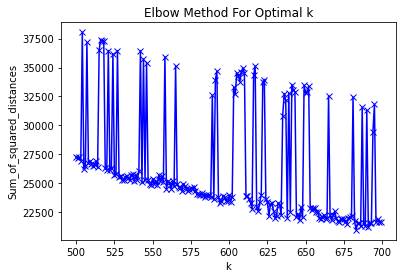

In [396]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [397]:
from sklearn import cluster
from scipy.spatial import distance
import sklearn.datasets
from sklearn.preprocessing import StandardScaler

In [402]:
data_chart_1

,ICUSTAY_ID,Cr,BUN,WBC,Bi,SS,Pl,Gender,Age_Patient,Race,...,CONGESTIVEHEARTFAILURE_ICD,HYPOTENSION_ICD,SEPSIS_ICD,OTHERINFECTION_ICD,CHRONICLIVERDISEASE_ICD,CHRONICLUNGDISEASE_ICD,ANEMIA_ICD,CARDIOVASCULARFAILURE_ICD,OBSTRUCTIVEUROPATHY_ICD,MECHANICAL_VENTILATION_ICD
0,200033.0,0.700000,18.000000,11.800000,24.000000,135.333333,165.000000,1.0,67.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
1,200033.0,0.700000,18.000000,10.850000,23.000000,136.500000,158.500000,1.0,67.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,200033.0,0.700000,16.666667,10.850000,23.000000,136.125000,158.500000,1.0,67.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,200033.0,0.700000,16.666667,9.833333,23.000000,136.111111,159.666667,1.0,67.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,200033.0,0.660000,15.200000,8.775000,23.400000,136.090909,152.750000,1.0,67.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96351,299957.0,0.600000,12.000000,8.500000,27.000000,142.000000,176.500000,0.0,60.0,5.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
96352,299957.0,0.650000,10.500000,8.100000,28.500000,141.500000,163.000000,0.0,60.0,5.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
96353,299957.0,0.733333,10.000000,8.100000,29.333333,140.000000,163.000000,0.0,60.0,5.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
96354,299957.0,0.750000,10.250000,8.100000,29.750000,139.000000,161.000000,0.0,60.0,5.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [403]:
data_chart_1.shape

(96356, 24)

In [404]:
d_array = np.array(data_chart_1)

In [405]:
d_array

array([[2.00033000e+05, 7.00000000e-01, 1.80000000e+01, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.00033000e+05, 7.00000000e-01, 1.80000000e+01, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.00033000e+05, 7.00000000e-01, 1.66666667e+01, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       ...,
       [2.99957000e+05, 7.33333333e-01, 1.00000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.99957000e+05, 7.50000000e-01, 1.02500000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.99957000e+05, 7.50000000e-01, 1.02500000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [406]:
d_array.shape

(96356, 24)

In [408]:
d_array_1 = data_chart_1.to_numpy()

In [409]:
d_array_1

array([[2.00033000e+05, 7.00000000e-01, 1.80000000e+01, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.00033000e+05, 7.00000000e-01, 1.80000000e+01, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.00033000e+05, 7.00000000e-01, 1.66666667e+01, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       ...,
       [2.99957000e+05, 7.33333333e-01, 1.00000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.99957000e+05, 7.50000000e-01, 1.02500000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.99957000e+05, 7.50000000e-01, 1.02500000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [410]:
d_array_1.shape

(96356, 24)

In [398]:
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 
             'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) - 
                  n[i] * np.log(N) - 
                  ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) - 
                  ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)

In [413]:
ks = range(700, 750)

KMeans = [cluster.KMeans(n_clusters = i, init="k-means++").fit(d_array) for i in ks]

BIC = [compute_bic(kmeansi,d_array) for kmeansi in KMeans]

print(BIC)

[-10858753.105794413, -10852116.794772292, -10859392.192258494, -10850084.219547663, -10840644.643044017, -10849045.071041882, -10855160.07445847, -10845740.14196797, -10846681.789897827, -10841140.207634201, -10836764.577424552, -10838897.54819492, -10839500.331434324, -10830449.405785091, -10837102.597361835, -10831778.645191034, -10838795.994488146, -10829390.736269465, -10823478.469344312, -10824757.541277392, -10824447.963836992, -10823632.311668502, -10823842.215049284, -10817708.877158029, -10818928.939799061, -10812705.670366634, -10811368.55656906, -10814734.208481018, -10814255.62009236, -10813310.957079437, -10811589.262700032, -10811184.818721613, -10806649.492232459, -10807224.207411757, -10794504.531674525, -10794962.981322162, -10790742.538368002, -10796764.378185166, -10793706.289666604, -10798058.91043267, -10792074.474077547, -10787908.692708144, -10787097.711445903, -10787546.460575951, -10788203.303391024, -10785427.14394775, -10784621.704770904, -10782936.849046804

In [415]:
KMeans

[KMeans(n_clusters=700),
 KMeans(n_clusters=701),
 KMeans(n_clusters=702),
 KMeans(n_clusters=703),
 KMeans(n_clusters=704),
 KMeans(n_clusters=705),
 KMeans(n_clusters=706),
 KMeans(n_clusters=707),
 KMeans(n_clusters=708),
 KMeans(n_clusters=709),
 KMeans(n_clusters=710),
 KMeans(n_clusters=711),
 KMeans(n_clusters=712),
 KMeans(n_clusters=713),
 KMeans(n_clusters=714),
 KMeans(n_clusters=715),
 KMeans(n_clusters=716),
 KMeans(n_clusters=717),
 KMeans(n_clusters=718),
 KMeans(n_clusters=719),
 KMeans(n_clusters=720),
 KMeans(n_clusters=721),
 KMeans(n_clusters=722),
 KMeans(n_clusters=723),
 KMeans(n_clusters=724),
 KMeans(n_clusters=725),
 KMeans(n_clusters=726),
 KMeans(n_clusters=727),
 KMeans(n_clusters=728),
 KMeans(n_clusters=729),
 KMeans(n_clusters=730),
 KMeans(n_clusters=731),
 KMeans(n_clusters=732),
 KMeans(n_clusters=733),
 KMeans(n_clusters=734),
 KMeans(n_clusters=735),
 KMeans(n_clusters=736),
 KMeans(n_clusters=737),
 KMeans(n_clusters=738),
 KMeans(n_clusters=739),


$A$: the finite set of actions available from state $s$ (in our model, the amount prescribed of those three medications converted into discrete decisions)

We focused on medical decisions regarding total amount of each of the three medications administered over each 12-h period 

**Question:** How do we define our action space?

- Cyclosporine

In [360]:
data_1

,ICUSTAY_ID,AMOUNT,Diff
0,207606.0,125.000007,125.000007
1,207606.0,125.000007,0.000000
2,207606.0,125.000007,0.000000
3,207606.0,125.000007,0.000000
4,207606.0,125.000007,0.000000
...,...,...,...
61,295808.0,150.000004,0.000000
62,295808.0,150.000004,0.000000
63,295808.0,150.000004,0.000000
64,295808.0,175.000004,25.000001


- Piperacillin

In [361]:
data_2

,ICUSTAY_ID,AMOUNT,Diff
0,200033.0,2.0,2.0
1,200033.0,4.0,2.0
2,200033.0,5.0,1.0
3,200033.0,7.0,2.0
4,200033.0,8.0,1.0
...,...,...,...
5624,299872.0,2.0,2.0
5625,299872.0,2.0,0.0
5626,299880.0,2.0,2.0
5627,299880.0,3.0,1.0


- Vancomycin

In [362]:
data_3.head(10)

,ICUSTAY_ID,AMOUNT,Diff
0,200033.0,2.0,2.0
1,200033.0,2.0,0.0
2,200033.0,4.0,2.0
3,200033.0,5.0,1.0
4,200033.0,5.0,0.0
...,...,...,...
58269,299957.0,1.0,1.0
58270,299957.0,2.0,1.0
58271,299957.0,3.0,1.0
58272,299957.0,4.0,1.0


To define the action space, the dose or the amount of each medication was represented as one of five possible choices, choice 1 being "no drug given" and the remaining non-null doses divided into < Q1, Q1-Q2(median), Q2-Q3, >Q3. The combination of the three medications would produce 125 possible discrete actions.

$T(s^{'}, s, a)$: the transition matrix, containing the probability that action $a$ in state $s$ at time $t$ will lead to state $s^{'}$ at time $t+1$, which describes the dynamicsof the system.

$R(s^{'})$: the immediate reward received for transitioning to state $s^{'}$. Transitions to desirable states yield a a positive reward, and reachin undesirable states generates a penalty.

In [414]:
patient_death = pd.read_csv('D:\\Pitt_1\\Research_0\\PATIENTS.csv')

In [416]:
patient_death

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
46515,31840,44089,M,2026-05-25 00:00:00,NaN,NaN,NaN,0
46516,31841,44115,F,2124-07-27 00:00:00,NaN,NaN,NaN,0
46517,31842,44123,F,2049-11-26 00:00:00,2135-01-12 00:00:00,2135-01-12 00:00:00,NaN,1
46518,31843,44126,F,2076-07-25 00:00:00,NaN,NaN,NaN,0


**Question:** How do we define our reward and penalty?

$\gamma$: the discount factor, which allows modelling of the fact that a future reward is worth less than an immediate reward